# Step 1

## Fetching Data and Exploratory Data Analysis

We look at the adjusted close prices of Google stock within the timeframe from January 1, 2016, to August 1, 2023.

 We look at the adjusted close prices, which consider factors like dividends and stock splits.  For example, the last stock split for Alphabet (GOOG) was on July 18, 2022. It was a 20:1 split, so for every share held, the shareholder received 20 shares.  The adjusted closing prices recalculate the historic prices in terms of the new shares.

In [3]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = "GOOG" # Google stock

# Set the timeframe for the data (start and end dates)
start_date = "2016-01-01"
end_date = "2023-08-01"

# Fetch the data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
stock_data = stock_data["Adj Close"]
# Display the fetched data
print(stock_data.head())  # Display the first few rows of the data


[*********************100%%**********************]  1 of 1 completed
Date
2016-01-04    37.091999
2016-01-05    37.129002
2016-01-06    37.181000
2016-01-07    36.319500
2016-01-08    35.723499
Name: Adj Close, dtype: float64


In [4]:
len(stock_data)

1906

Here is a plot of the adjusted closing price for Google for the specified time period:

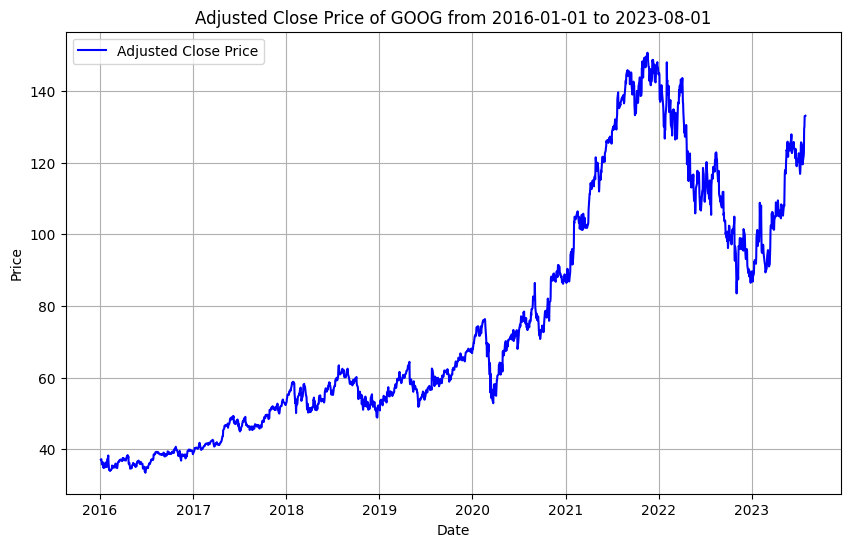

In [5]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data, label="Adjusted Close Price", color='blue')
plt.title(f"Adjusted Close Price of {ticker_symbol} from {start_date} to {end_date}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(stock_data.describe())

count    1906.000000
mean       75.971957
std        33.502041
min        33.412998
25%        50.879625
50%        61.817751
75%       103.751499
max       150.709000
Name: Adj Close, dtype: float64


We extract the series of daily returns by looking at the percent change between the previous closing price and the current closing price on each day.

In [7]:
daily_returns = stock_data.pct_change().dropna()

In [8]:
daily_returns

Date
2016-01-05    0.000998
2016-01-06    0.001400
2016-01-07   -0.023170
2016-01-08   -0.016410
2016-01-11    0.002183
                ...   
2023-07-25    0.007466
2023-07-26    0.055949
2023-07-27    0.001620
2023-07-28    0.024178
2023-07-31    0.000752
Name: Adj Close, Length: 1905, dtype: float64

We have approximately 1900 observations of the closing stock price for each trading day between January 1, 2016 to August 1, 2023.  We can perform exploratory data analysis.  First we look at a histogram of the distribution of daily returns.

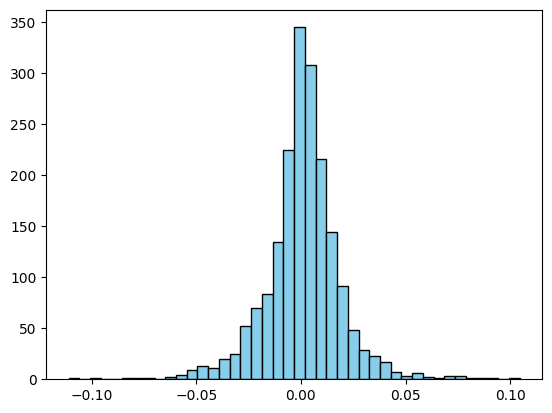

In [9]:
plt.hist(daily_returns, bins=42, color='skyblue', edgecolor='black');

In order to check for stationarity, we can look at a plot of the rolling mean and standard deviation for 30 days.  In addition, we can use the Augmented Dickey-Fuller test.

Skewness of Daily Returns: -0.034619033433453586


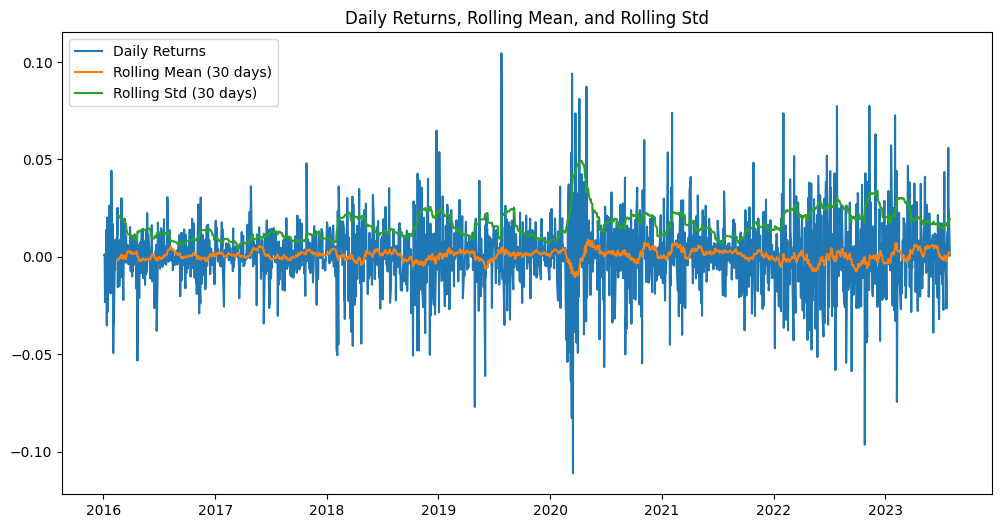

Augmented Dickey-Fuller Test:
ADF Statistic: -10.474676345429227
p-value: 1.257996195534125e-18
Critical Values:
   1%: -3.4338294057711836
   5%: -2.863076961232155
   10%: -2.567588221339588


In [ ]:
import matplotlib.pyplot as plt

# Stationarity check
def check_stationarity(series):
    # Rolling statistics
    rolling_mean = series.rolling(window=30).mean()
    rolling_std = series.rolling(window=30).std()

    # Plotting rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Daily Returns')
    plt.plot(rolling_mean, label='Rolling Mean (30 days)')
    plt.plot(rolling_std, label='Rolling Std (30 days)')
    plt.legend()
    plt.title('Daily Returns, Rolling Mean, and Rolling Std')
    plt.show()

    # Augmented Dickey-Fuller test for stationarity
    from statsmodels.tsa.stattools import adfuller
    adf_result = adfuller(series)
    print('Augmented Dickey-Fuller Test:')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')

# Skewness calculation
skewness = daily_returns.skew()

# Printing skewness value
print(f'Skewness of Daily Returns: {skewness}')

# Check for stationarity
check_stationarity(daily_returns)

We also look at the distribution of daily returns and compare it to the normal distribution.

We can conclude that the series of daily returns is stationary by using the Augmented Dickey-Fuller test. The Augmented Dickey-Fuller (ADF) test checks if a time series variable is non-stationary, meaning it might have a unit root. The test assumes a null hypothesis that the series possesses a unit root, opposed to an alternative suggesting otherwise.

We do a test regression using ordinary least squares:

$$
\Delta y_t = \alpha  + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \dots + \epsilon_t
$$

Here, $y_t$ is the time series variable, $\Delta y_t$ is its first difference ($y_t - y_{t-1}$), $\alpha$ is the constant, and $\epsilon_t$ represents the error term.

We test the the null hypothesis that $\gamma = 0$ and determine that we can reject the null hypothesis that the series has a unit root.


In [ ]:
kurtosis_value = daily_returns.kurtosis()

# Print the kurtosis value
print(f'Kurtosis of Daily Returns: {kurtosis_value}')

Kurtosis of Daily Returns: 4.381913154142148


The kurtosis value helps understand the shape of the distribution:

- A kurtosis value of 3 indicates a normal distribution (mesokurtic).
- Kurtosis greater than 3 suggests heavy tails (leptokurtic) with more frequent extreme values.
- Kurtosis less than 3 indicates light tails (platykurtic) with fewer extreme values compared to a normal distribution.

We have a kurtosis of 4.38 which indicates heavy tails in the distribution of returns.

In [ ]:
from scipy.stats import shapiro

# Shapiro-Wilk test for normality
normality_test = shapiro(daily_returns)

# Print the test statistic and p-value
print(f'Shapiro-Wilk Test Statistic: {normality_test.statistic}')
print(f'p-value: {normality_test.pvalue}')

# Interpretation of the p-value
alpha = 0.05  # Chosen significance level
if normality_test.pvalue > alpha:
    print('The data seems to be normally distributed (fail to reject H0)')
else:
    print('The data does not appear to be normally distributed (reject H0)')


Shapiro-Wilk Test Statistic: 0.9424307942390442
p-value: 1.3081657280120706e-26
The data does not appear to be normally distributed (reject H0)


Applying the Shapiro-Wilk test indicates that the distribution of daily returns differs from a normal distribution.

## Training a Fully-Connected Multilayer Perceptron Model

We introduce deliberate leakage by making an incorrect choice of the target label to include a return that is covered by the feature data.
Leakage occurs when information in the training data is also present in the test data due to serial correlation.  We put the test data starting immediately after the end of the training data, the beginning of the test data should be similar and we should have leakage from this source as well.


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
look_back = 30

X, y = [], []

for i in range(len(daily_returns) - look_back):
    X.append(daily_returns[i:i+look_back])
    # Assign 1 for positive differences, 0 for negative differences
    y.append(daily_returns[i+look_back-1])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=look_back))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
47/47 [==============================] - 1s 6ms/step - loss: 0.0311
Epoch 2/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 3/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4/50
47/47 [==============================] - 0s 5ms/step - loss: 4.4899e-04
Epoch 5/50
47/47 [==============================] - 0s 5ms/step - loss: 2.4872e-04
Epoch 6/50
47/47 [==============================] - 0s 5ms/step - loss: 1.7190e-04
Epoch 7/50
47/47 [==============================] - 0s 5ms/step - loss: 1.3793e-04
Epoch 8/50
47/47 [==============================] - 0s 5ms/step - loss: 9.3246e-05
Epoch 9/50
47/47 [==============================] - 0s 5ms/step - loss: 5.8849e-05
Epoch 10/50
47/47 [==============================] - 0s 4ms/step - loss: 4.7818e-05
Epoch 11/50
47/47 [==============================] - 0s 5ms/step - loss: 4.5118e-05
Epoch 12/50
47/47 [==============================] - 0s 5ms/step - loss: 3.4130e-05
Epoch 13/50
4

In [ ]:
test_loss = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)


12/12 [==============================] - 0s 3ms/step


We achieve an out of sample R-squared score of 0.185 which is high for stock return prediction.  This is indicative of the leakage involved.

In [ ]:
from sklearn.metrics import r2_score

# Calculate the R-squared score for y_test and y_pred
r_squared = r2_score(y_test, y_pred)

print(f"R-squared score: {r_squared}")

R-squared score: 0.1853691878476924


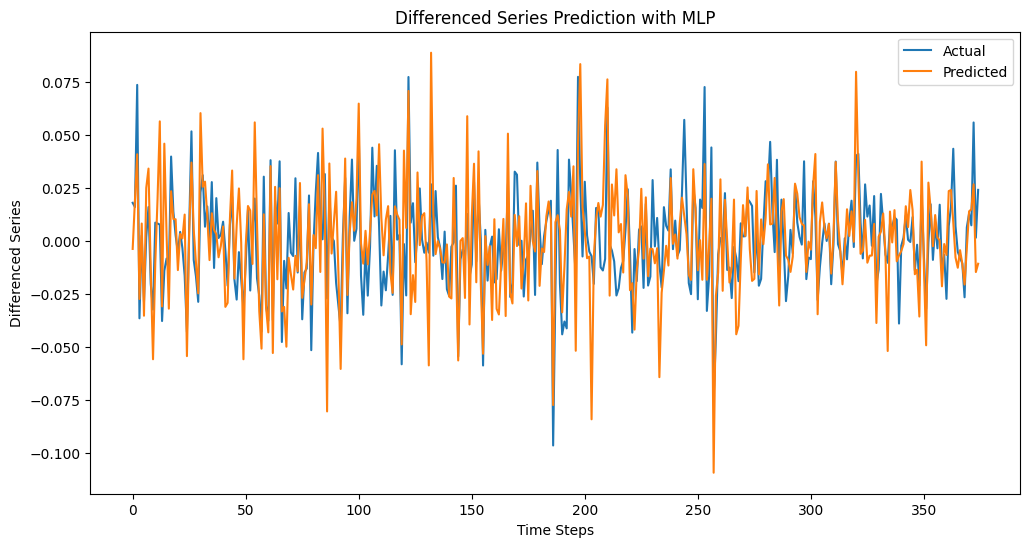

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Differenced Series Prediction with MLP")
plt.xlabel("Time Steps")
plt.ylabel("Differenced Series")
plt.legend()
plt.show()

This backtesting code evaluates a trading strategy based on signals derived from our predictive model. We check if the comparing predicted returns are positive or negative; we are long when the predicted return is positive; otherwise we hold cash. We track positions and profit/loss (PnL), then simulate trades based on these signals. We iterate through the test data, considering the positions taken and the actual returns.

In [ ]:
# Signal generation
threshold = 0.0
signals = [1 if pred_return > threshold else -1 for pred_return in y_pred]

# Initialize variables for tracking positions and PnL
position = 0  # 1 for long, -1 for short, 0 for neutral
PnL = []
bh_return = []
# Function to calculate the product of a list
def product(lst):
    result = 1
    for num in lst:
        result *= num
    return result

cum = 1
# Trading logic and backtesting
for i in range(len(y_test)):
    # Execute trade based on the signal
    if signals[i] == 1:  # Buy if signal is positive and not already long
        position = 1
    elif signals[i] == -1:  # Sell if signal is negative
        position = 0

    # Calculate daily PnL based on actual returns and positions
    daily_return = y_test[i] * position if position != 0 else 0
    PnL.append(1 + daily_return)
    cum *= (1 + y_test[i])
    bh_return.append(cum - 1)

# Calculate cumulative PnL
cumulative_PnL = [product(PnL[:i+1]) - 1 for i in range(len(PnL))]
# Analyze performance metrics (e.g., cumulative return, Sharpe ratio, etc.)
cumulative_return = cumulative_PnL[-1]



Using a multilevel perceptron to calculate predicted returns we get a cumulative return of approximately 798 per cent for the test period.

In [ ]:
cumulative_return

7.981100650739119

Here is a plot of the cumulative return for our strategy.

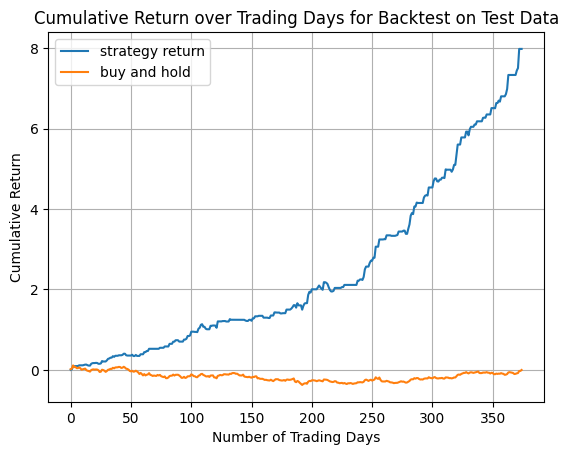

In [ ]:
plt.plot(np.array(cumulative_PnL), label="strategy return")
plt.plot(np.array(bh_return), label="buy and hold")
plt.xlabel('Number of Trading Days')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return over Trading Days for Backtest on Test Data')
plt.grid(True)
plt.legend()
plt.show()

## Training a Long-Term Short-Term Memory Model

In [11]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
47/47 [==============================] - 28s 462ms/step - loss: 2.8647e-04 - val_loss: 5.5285e-04
Epoch 2/50
47/47 [==============================] - 21s 449ms/step - loss: 2.7487e-04 - val_loss: 5.5960e-04
Epoch 3/50
47/47 [==============================] - 21s 452ms/step - loss: 2.7011e-04 - val_loss: 5.7196e-04
Epoch 4/50
47/47 [==============================] - 20s 419ms/step - loss: 2.7000e-04 - val_loss: 5.5238e-04
Epoch 5/50
47/47 [==============================] - 21s 452ms/step - loss: 2.6731e-04 - val_loss: 5.5355e-04
Epoch 6/50
47/47 [==============================] - 20s 420ms/step - loss: 2.7119e-04 - val_loss: 5.7126e-04
Epoch 7/50
47/47 [==============================] - 22s 475ms/step - loss: 2.6959e-04 - val_loss: 5.7688e-04
Epoch 8/50
47/47 [==============================] - 20s 425ms/step - loss: 2.6951e-04 - val_loss: 5.5251e-04
Epoch 9/50
47/47 [==============================] - 21s 451ms/step - loss: 2.6619e-04 - val_loss: 5.5233e-04
Epoch 10/50
47/47 [

We repeat the backtesting procedure for the LSTM model.

In [12]:
from sklearn.metrics import r2_score
test_loss = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
# Calculate the R-squared score for y_test and y_pred
r_squared = r2_score(y_test, y_pred)

print(f"R-squared score: {r_squared}")

12/12 [==============================] - 2s 96ms/step
R-squared score: -0.01271043635751079


Despite the deliberate leak we achieve an out of sample R-squared score of -0.012.

In [13]:
# Signal generation
threshold = 0.0
signals = [1 if pred_return > threshold else -1 for pred_return in y_pred]

# Initialize variables for tracking positions and PnL
position = 0  # 1 for long, -1 for short, 0 for neutral
PnL = []

# Function to calculate the product of a list
def product(lst):
    result = 1
    for num in lst:
        result *= num
    return result

cum = 1
bh_return = []
# Trading logic and backtesting
for i in range(len(y_test)):
    # Execute trade based on the signal
    if signals[i] == 1:  # Buy if signal is positive and not already long
        position = 1
    elif signals[i] == -1:  # Sell if signal is negative
        position = 0

    # Calculate daily PnL based on actual returns and positions
    daily_return = y_test[i] * position if position != 0 else 0
    PnL.append(1 + daily_return)
    cum *= (1 + y_test[i])
    bh_return.append(cum - 1)


# Calculate cumulative PnL
cumulative_PnL = [product(PnL[:i+1]) - 1 for i in range(len(PnL))]

# Analyze performance metrics (e.g., cumulative return, Sharpe ratio, etc.)
cumulative_return = cumulative_PnL[-1]

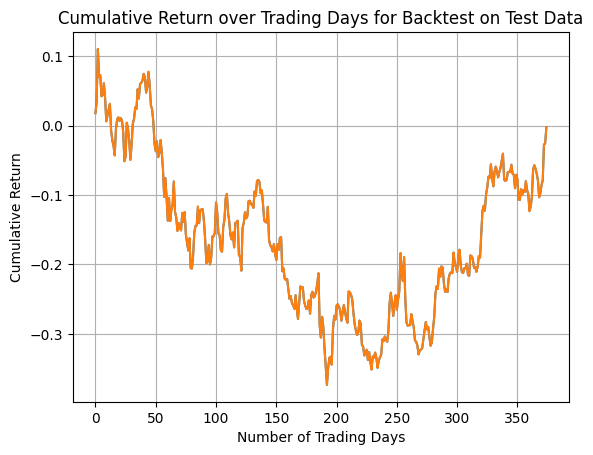

In [14]:
plt.plot(np.array(cumulative_PnL))
plt.plot(bh_return)
plt.xlabel('Number of Trading Days')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return over Trading Days for Backtest on Test Data')
plt.grid(True)
plt.show()

In [15]:
cumulative_return

-0.0020970180513221193

Applying a LSTM model to the prediction of daily returns yields a strategy that almost always decides to buy and hold.  We get a cumulative return of -0.2% over the test period.  We get a R-squared score of -0.012 which is similar to forecasting a constant return.

The LSTM architecture includes LSTM layers for capturing time dependencies, followed by fully-connected dense layers. However, the resulting model fails to effectively predict returns. The model essentially decides to always goes long, rather than successfully predicting positive or negative returns. Overall, the LSTM model demonstrates very limited forecasting ability on this financial time series data. The recurrent nature of the model does not seem to provide an advantage for predicting returns in this application.

## Training a Convolutional Neural Network using Gramian Angular Field

We split the data into windows of 30 days each, and turn each window into a 30x30 image using the Gramian Angular Field method.  The time series values are transformed to fit within the range of [-1, 1]. The inverse cosine function is applied element-wise to the scaled time series.
We create a $30\times30$ matrix by performing an outer sum operation on the arccosine-transformed series. The we apply cosine to each element of the resulting matrix from the outer sum. The resulting matrix represents the Gramian Angular Field (GAF) representation of the input time series.

In [18]:
import numpy as np

X_train = []
window_size = 30
for i in range(window_size, stock_data.shape[0]-1):
    X_train.append(daily_returns[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])

(1875, 30)


In [20]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.5 MB/s eta 0:00:00


In [21]:
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1875, 30, 30)


Here are some plots of the Gramian Angular Field produced by looking at a window of 30 days on the series of daily returns.

(30, 30)


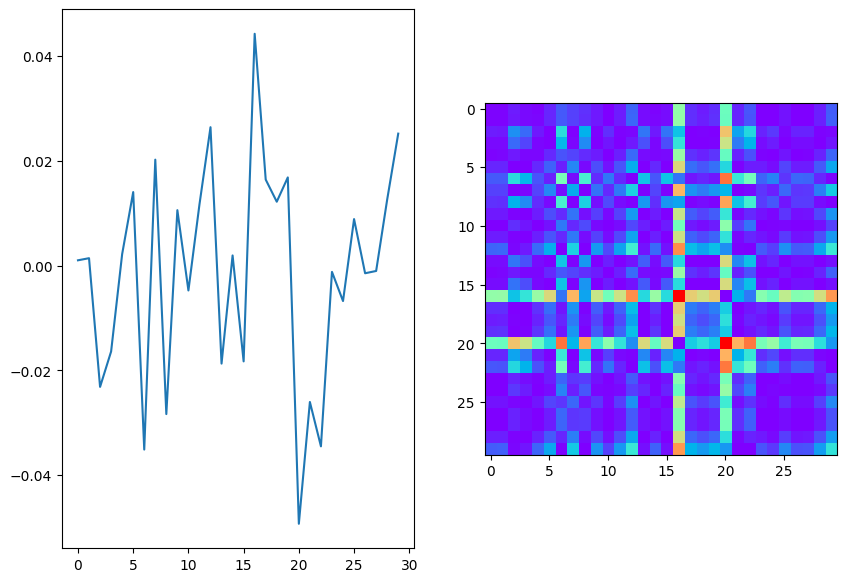

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train[0, :])
ax[1].imshow(X_train_new[0], cmap="rainbow")
print(X_train_new[0].shape)

In [24]:
window_size=30
y_data = []
for i in range(window_size, daily_returns.shape[0]-1):
    y_data.append(daily_returns[i-1])
y_data = np.array(y_data)

Having produced the Gramian Angular Field matrix, we rescale to the range [0,255].

In [25]:

# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape
# Split into train and test
train_split = 0.8
y_data_train = y_data[: 1500]
y_data_test = y_data[1500 :]
X_data_train = X_data[: 1500]
X_data_test = X_data[1500 :-1]

We train a convolutional neural network using the Gramian Angular Field data. We set up a CNN architecture commonly used for image classification tasks, consisting of convolutional layers for feature extraction, max-pooling for dimensionality reduction, and densely connected layers for classification. The use of dropout aids in preventing overfitting during training.







In [26]:
import tensorflow as tf
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(128, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1))

In [27]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [28]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
)

Epoch 1/50
47/47 [==============================] - 16s 252ms/step - loss: 479.9441 - val_loss: 0.0023
Epoch 2/50
47/47 [==============================] - 10s 218ms/step - loss: 0.0016 - val_loss: 8.1482e-04
Epoch 3/50
47/47 [==============================] - 7s 140ms/step - loss: 8.9545e-04 - val_loss: 6.6095e-04
Epoch 4/50
47/47 [==============================] - 8s 170ms/step - loss: 8.0724e-04 - val_loss: 6.4530e-04
Epoch 5/50
47/47 [==============================] - 6s 134ms/step - loss: 6.2508e-04 - val_loss: 6.5424e-04
Epoch 6/50
47/47 [==============================] - 7s 145ms/step - loss: 6.4875e-04 - val_loss: 6.1488e-04
Epoch 7/50
47/47 [==============================] - 4s 78ms/step - loss: 6.0912e-04 - val_loss: 5.9427e-04
Epoch 8/50
47/47 [==============================] - 4s 79ms/step - loss: 5.3095e-04 - val_loss: 6.0093e-04
Epoch 9/50
47/47 [==============================] - 5s 106ms/step - loss: 5.1561e-04 - val_loss: 5.7834e-04
Epoch 10/50
47/47 [===================

In [29]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_data_test)
# Calculate the R-squared score for y_test and y_pred
r_squared = r2_score(y_data_test, y_pred)

print(f"R-squared score: {r_squared}")

12/12 [==============================] - 0s 15ms/step
R-squared score: -0.00390873082887544


We transform the time series data into image-like representations using the Gramian Angular Field (GAF) technique. GAF renders time series as images capturing temporal relationships. We generate 30x30 pixel GAF images from 30-day windows of the daily returns data. We use these image transformations to train a convolutional neural network (CNN) model commonly applied to image classification tasks. The architecture has convolutional layers to extract features, pooling layers to reduce dimensions, densely-connected layers, and dropout of 50% to prevent overfitting. However, the CNN model trained on the GAF images is unable to effectively predict actual returns. The R-squared score of -0.0036 indicates a very poor fit. The test set performance shows the model fails to learn an effective mapping from the images to the time series values. So the GAF representation does not lead to useful predictive modeling in this financial forecasting application, despite transforming the data into image form amenable to computer vision CNN models.

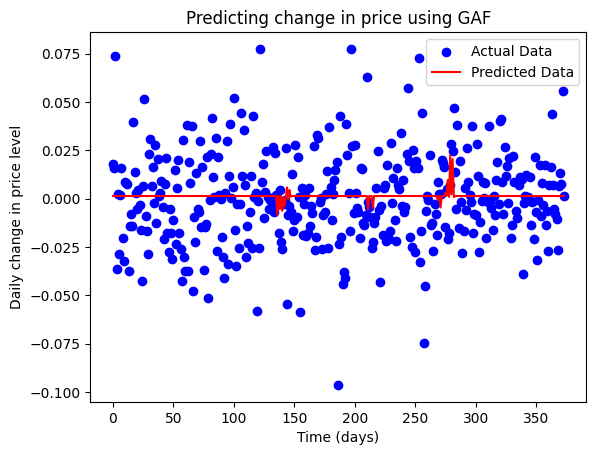

In [30]:
# Plotting the actual data (y_data_test)
plt.scatter(range(len(y_data_test)), y_data_test, label='Actual Data', color='blue')

# Plotting the predicted data (y_pred)
plt.plot(range(len(y_pred)), y_pred, label='Predicted Data', color='red')

# Adding labels and a legend
plt.xlabel('Time (days)')
plt.ylabel('Daily change in price level')
plt.title("Predicting change in price using GAF")
plt.legend()

In [48]:
# Signal generation
threshold = 0.0
signals = [1 if pred_return > threshold else -1 for pred_return in y_pred]

# Initialize variables for tracking positions and PnL
position = 0  # 1 for long, -1 for short, 0 for neutral
PnL = []

# Function to calculate the product of a list
def product(lst):
    result = 1
    for num in lst:
        result *= num
    return result

cum = 1
bh_return = []
# Trading logic and backtesting
for i in range(len(y_test)-1):
    # Execute trade based on the signal
    if signals[i] == 1:  # Buy if signal is positive and not already long
        position = 1
    elif signals[i] == -1:  # Sell if signal is negative
        position = 0

    # Calculate daily PnL based on actual returns and positions
    daily_return = y_test[i] * position if position != 0 else 0
    PnL.append(1 + daily_return)
    cum *= (1 + y_test[i])
    bh_return.append(cum - 1)
# Calculate cumulative PnL
cumulative_PnL = [product(PnL[:i+1]) - 1 for i in range(len(PnL))]

# Analyze performance metrics (e.g., cumulative return, Sharpe ratio, etc.)
cumulative_return = cumulative_PnL[-1]

Using the Gramian Angular Field method also yields an almost constant prediction, leading to a strategy that resembles the buy and hold strategy.  We end up with a cumulative return of 2 per cent, as we are able to avoid some losses.

In [49]:
cumulative_return

0.021654902443670077

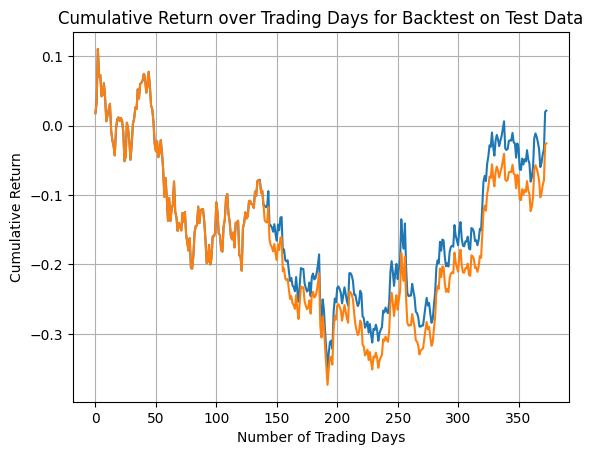

In [50]:
plt.plot(np.array(cumulative_PnL), label="strategy return")
plt.plot(np.array(bh_return), label="buy and hold return")
plt.xlabel('Number of Trading Days')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return over Trading Days for Backtest on Test Data')
plt.grid(True)
plt.show()

# Step 2

## Walk-Forward Validation

### Part a

#### Multi-level Perceptron model

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [52]:
# Assuming you have defined and preprocessed your daily_returns data

def walk_forward_validation(model, X, y, window_size=500):
    predictions = []
    actual_returns = []

    for i in range(0, len(X) - window_size, window_size):
        X_train, X_test = X[i:i+window_size], X[i+window_size:i+2*window_size]
        y_train, y_test = y[i:i+window_size], y[i+window_size:i+2*window_size]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

        # Append actual returns
        actual_returns.append(y_test)

    return predictions, actual_returns

# Assuming you have initialized your model, compiled it, and defined X, y

# Define your neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=look_back))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Perform walk-forward validation
predictions, actual_returns = walk_forward_validation(model, X, y)



12/12 [==============================] - 0s 3ms/step


In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)

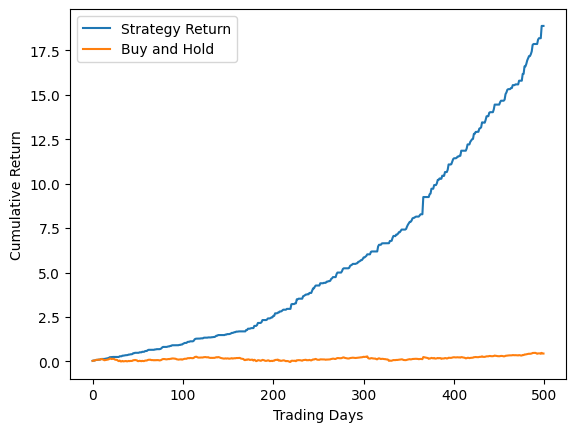

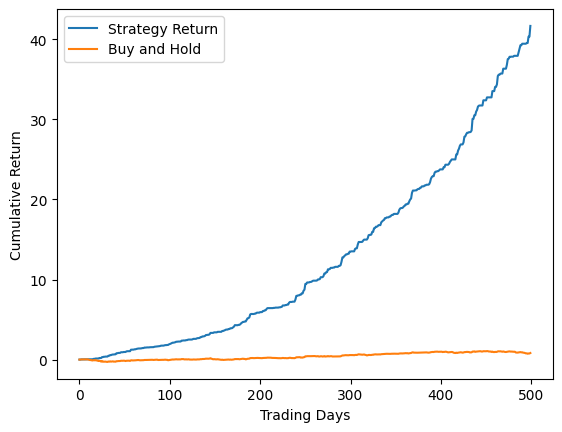

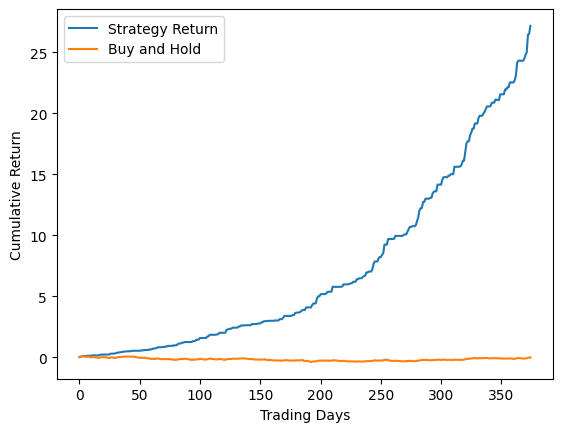

In [ ]:
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(len(signal)):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

Using a walk-forward validation with 500 days in the train and test period, we are able to beat the returns of a buy and hold strategy significantly.  However, this appears to be suprious, as the results are much better than the buy and hold strategy, yielding cumulative returns of over 1000% for each period.

### Long-Term Short Term Memory Model

In [53]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
# Perform walk-forward validation
predictions, actual_returns = walk_forward_validation(model, X, y)

12/12 [==============================] - 1s 93ms/step


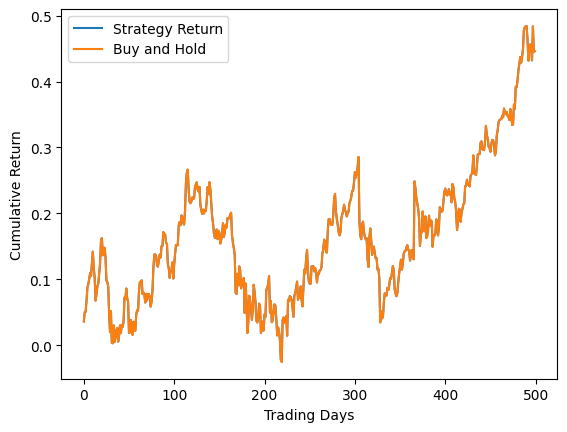

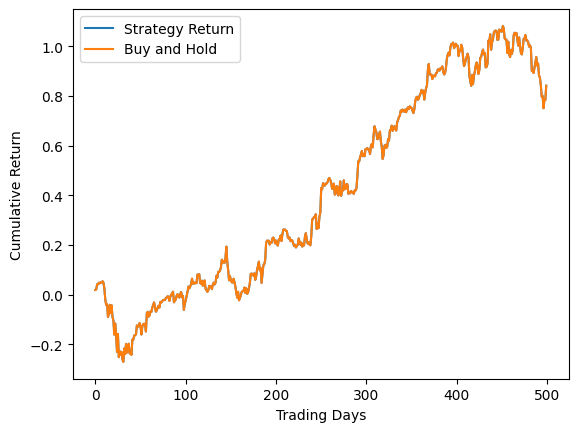

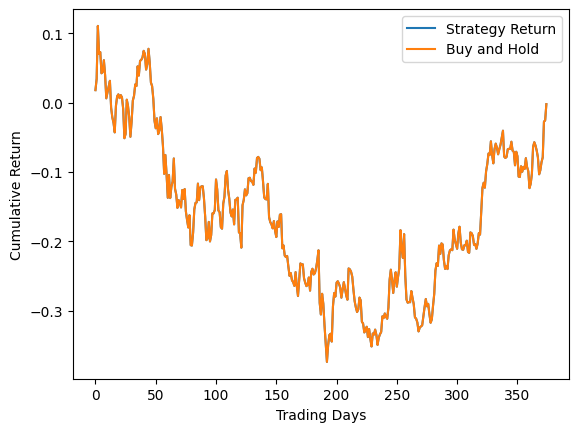

In [55]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(len(signal)):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

We repeat the same procedure for performing a walk-forward validation using the Long-Term Short-Term Memory Model.  We get that the strategy obtained by using the model's predictions is constant or nearly constant, thereby achieving similar returns to the buy and hold model.

In [59]:
import numpy as np
X_train = []
window_size = 30
for i in range(window_size, daily_returns.shape[0]-1):
    X_train.append(daily_returns[i - window_size: i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])

(1874, 30)


In [60]:
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1874, 30, 30)


In [ ]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.2 MB/s eta 0:00:00


In [61]:
y_data = []
for i in range(window_size, daily_returns.shape[0]):
    y_data.append(daily_returns[i-1])
y_data = np.array(y_data)

In [62]:

# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1874, 30, 30)

In [63]:
import tensorflow as tf
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(128, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1))

In [64]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [65]:
def walk_forward_validation(model, X, y, window_size=500, test_size=100):
    predictions = []
    actual_returns = []

    for i in range(0, len(X) - window_size, window_size):
        X_train, X_test = X[i:i+window_size], X[i+window_size:i+2*window_size]
        y_train, y_test = y[i:i+window_size], y[i+window_size:i+2*window_size]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

        # Append actual returns
        actual_returns.append(y_test)

    return predictions, actual_returns


In [66]:
predictions, actual_returns = walk_forward_validation(model, X_data, y_data)

12/12 [==============================] - 0s 15ms/step


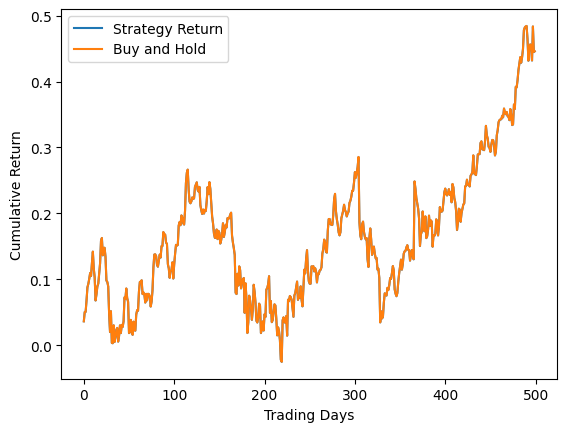

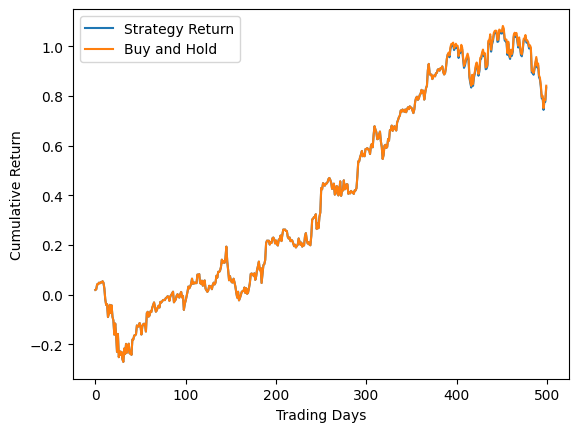

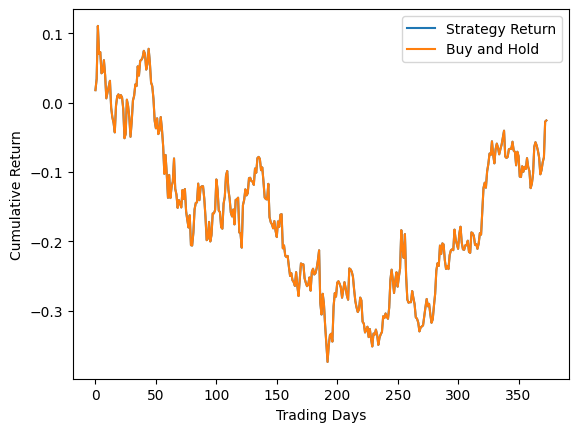

In [67]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()


We repeat the same procedure for performing a walk-forward validation using the Convolutional Neural Network trained on the Gramian Angular Field.  We get that we achieve similar results to the buy and hold strategy.




In [ ]:
def walk_forward_validation2(model, X, y, window_size=500, test_size=100):
    predictions = []
    actual_returns = []

    for i in range(0, len(X) - window_size, test_size):
        X_train, X_test = X[i:i+window_size], X[i+window_size:i+window_size + test_size]
        y_train, y_test = y[i:i+window_size], y[i+window_size:i+window_size + test_size]

        # Train the model
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

        # Append actual returns
        actual_returns.append(y_test)

    return predictions, actual_returns

### Part b

#### Mult-level Perceptron Model

We repeat the same experiment but with only 100 observations in the test set.

In [ ]:

# Define your neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=look_back))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError())
predictions, actual_returns = walk_forward_validation2(model, X, y)

3/3 [==============================] - 0s 4ms/step


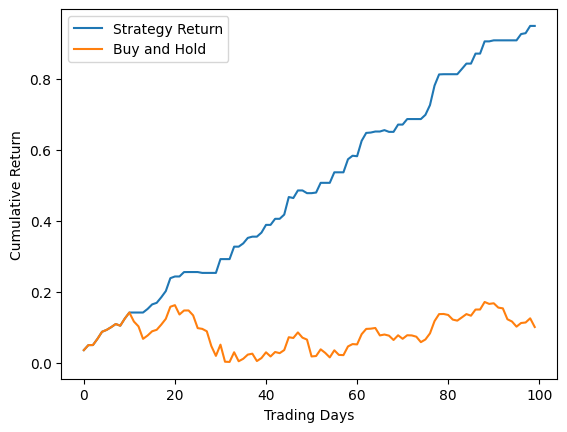

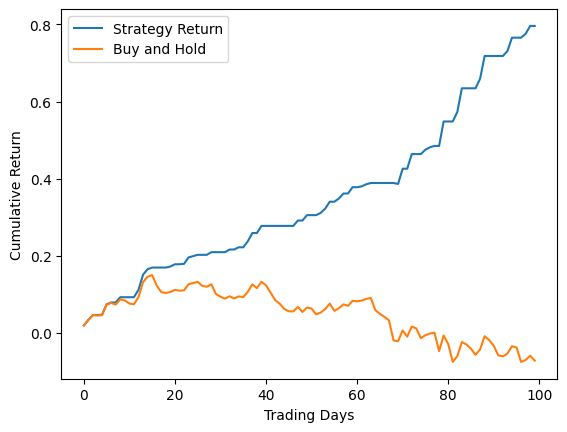

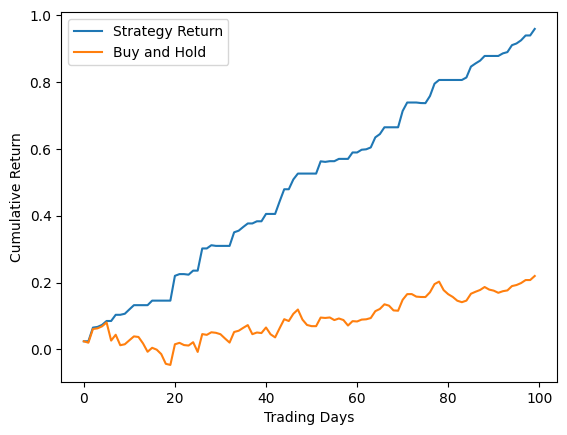

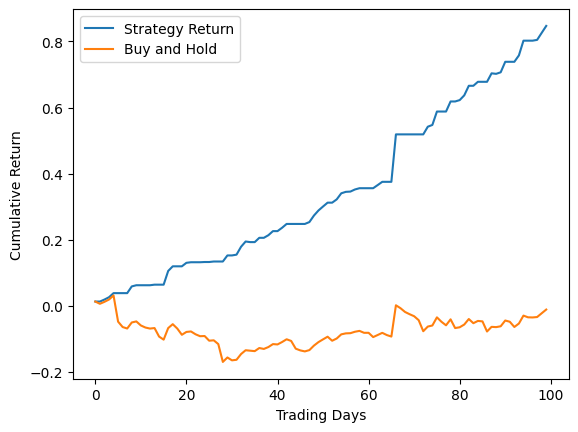

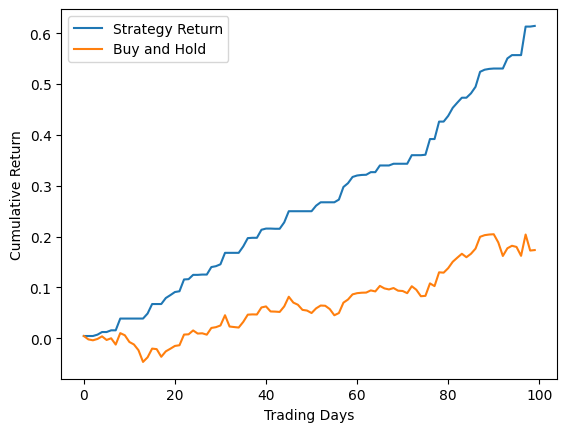

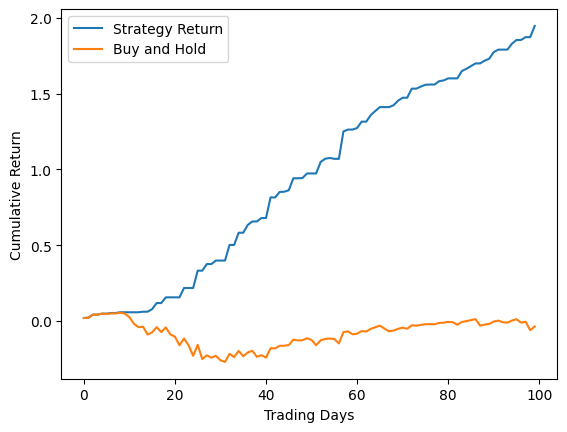

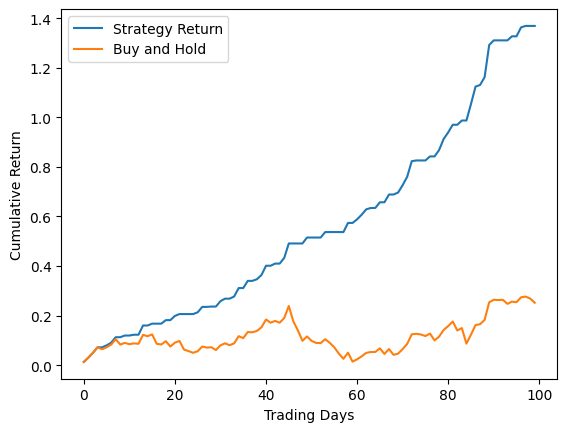

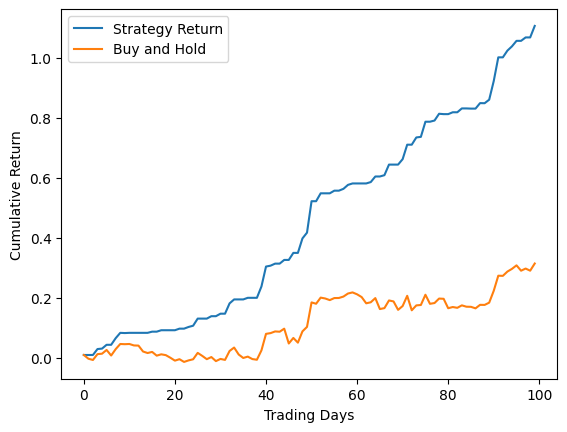

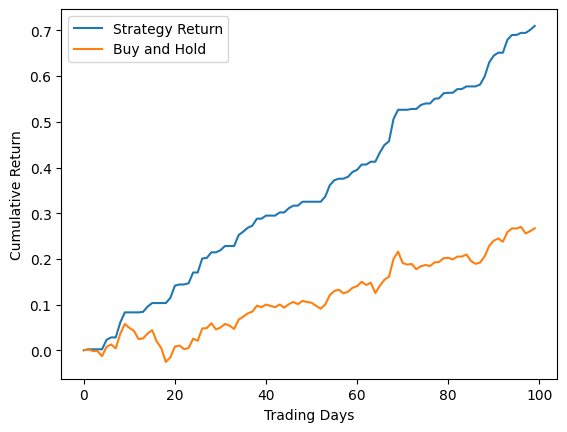

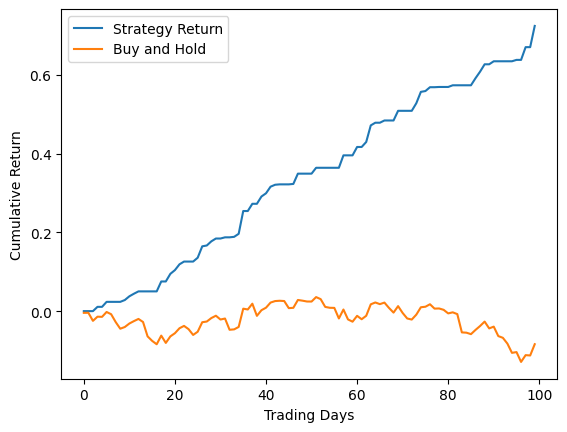

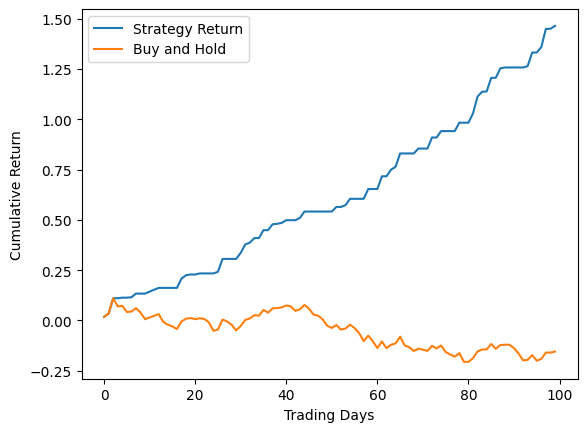

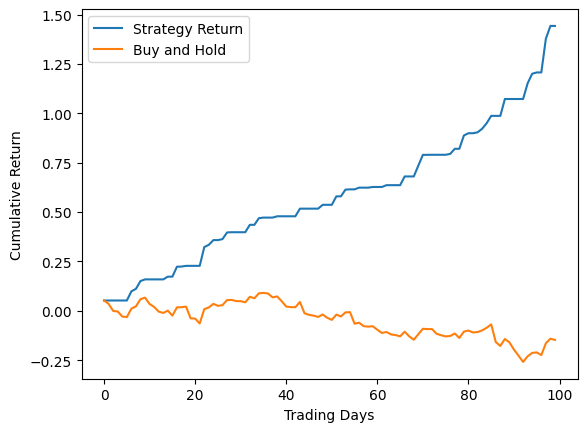

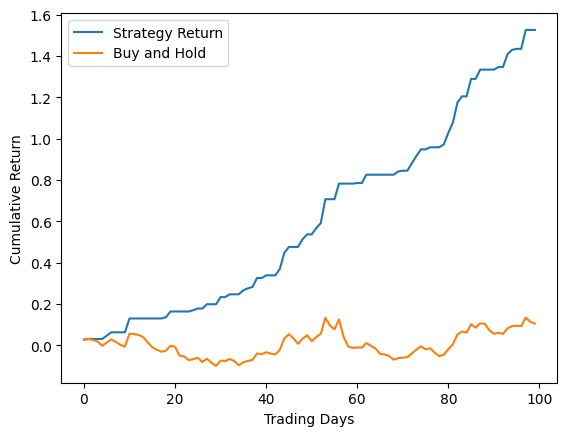

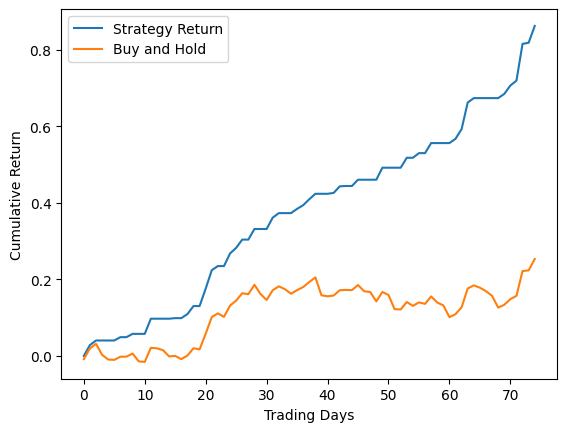

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

#### Long Term Short Term Memory

If we decrease the test set to 100 observations, we end up with the model giving a flat prediction again (either always long, or always hold cash).  This means that we have the same results as either a buy and hold strategy or a zero return.  This suggests that the long term short term memory model is not effective for predicting stock returns.

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Perform walk-forward validation
predictions, actual_returns = walk_forward_validation2(model, X, y)

3/3 [==============================] - 0s 119ms/step


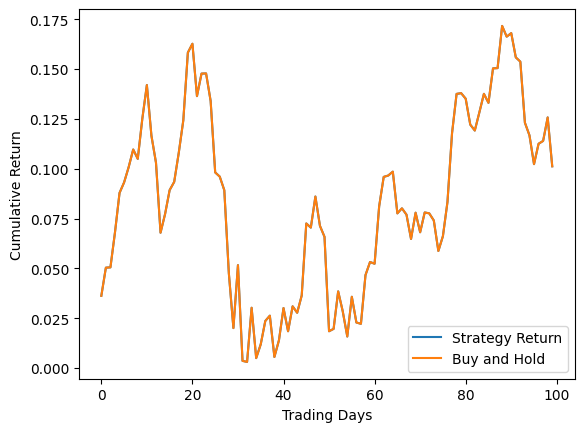

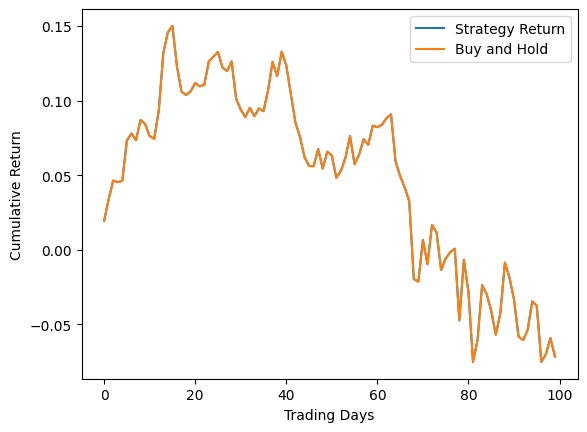

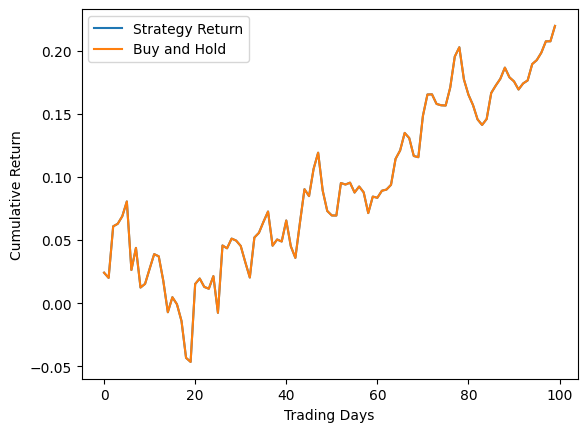

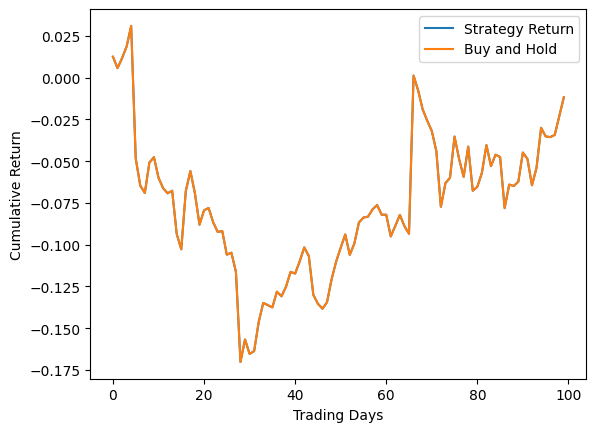

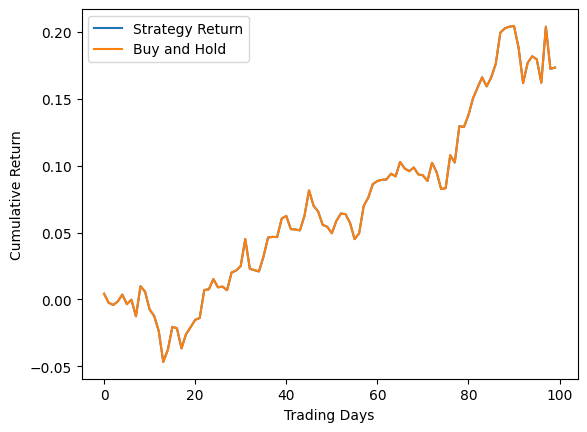

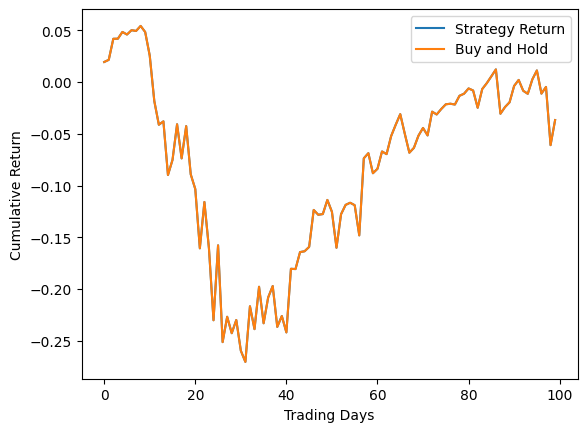

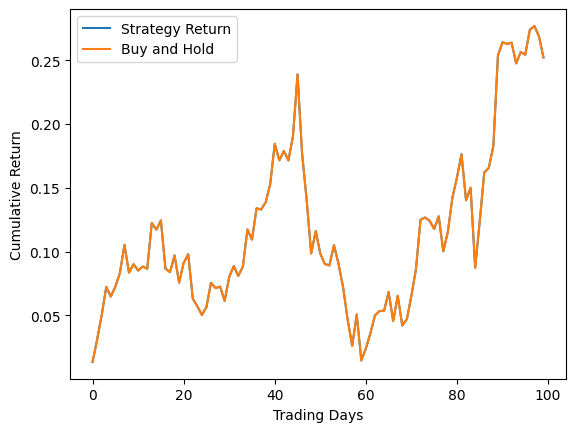

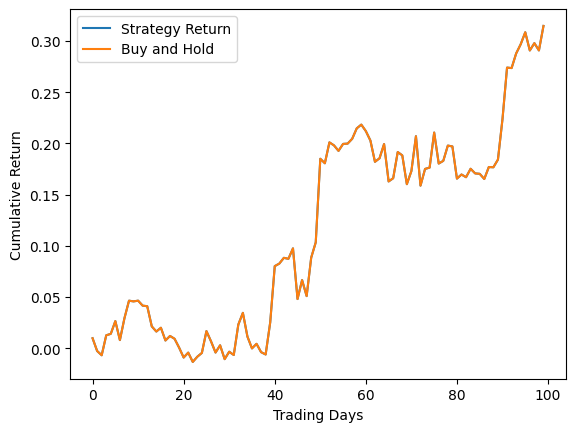

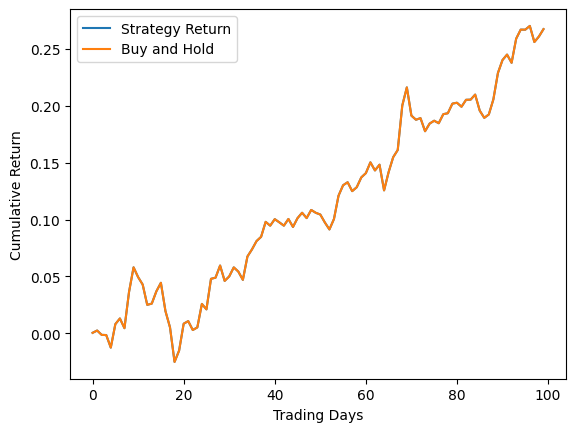

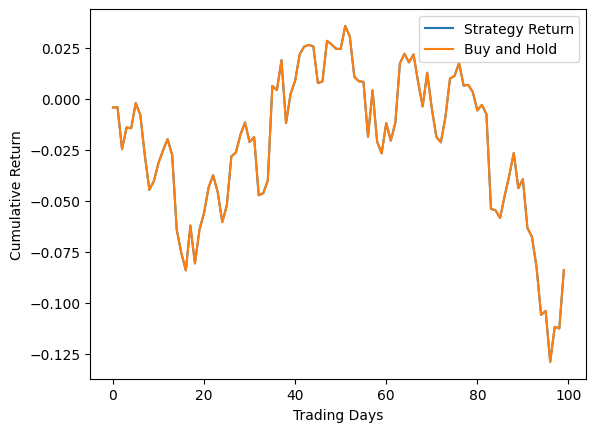

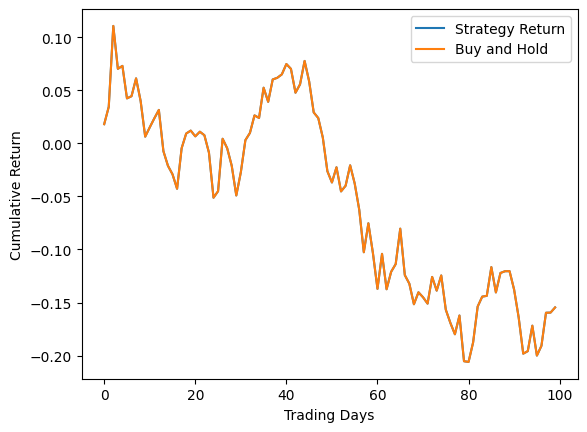

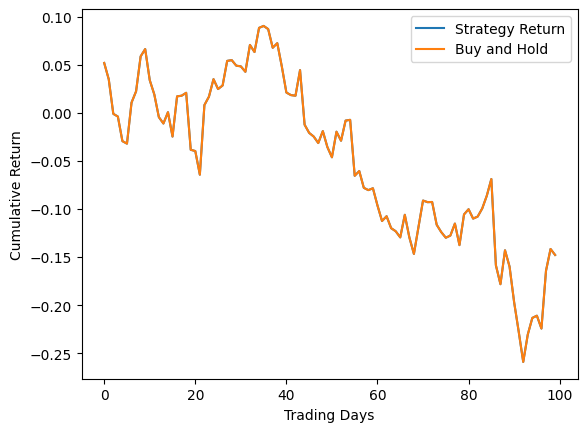

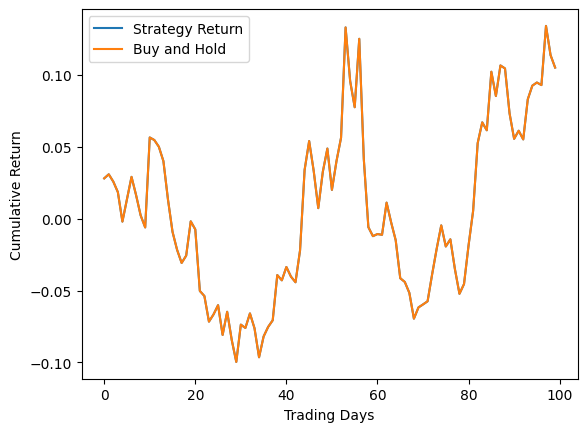

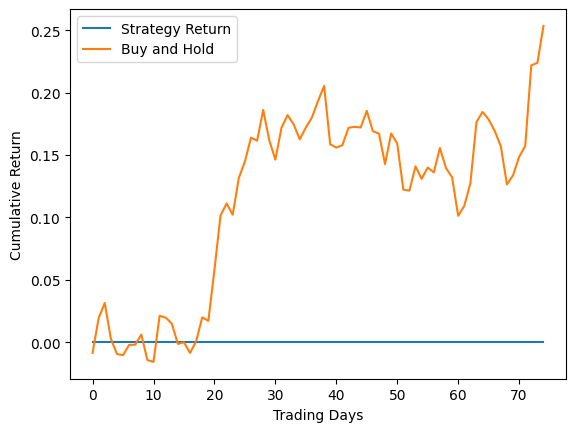

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

### Convolutional Neural Network using Gramian Angular Field

When applying convolutional neural network with Gramian Angular Field to the problem of predicting stock returns using a walk-forward validation with 500 training entries and 100 testing entries, we get that we almost always decide to go long.  This yields a return similar to that of the buy and hold strategy.  This also occurred in part a.  This suggests that the Gramian Angular Field is not effective in predicting the returns for Google stock.

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(128, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=True)

In [ ]:
# Perform walk-forward validation
predictions, actual_returns = walk_forward_validation2(model, X_data, y_data)

3/3 [==============================] - 0s 26ms/step


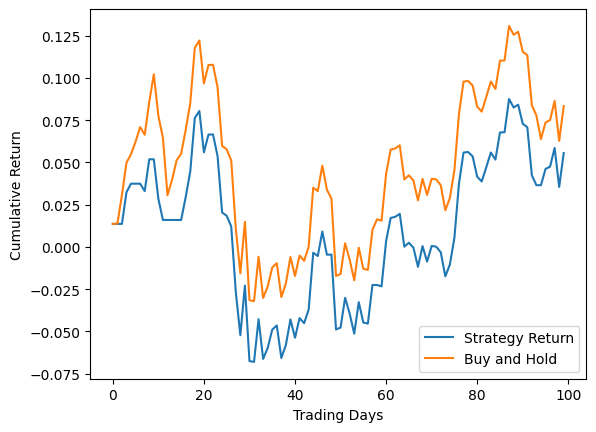

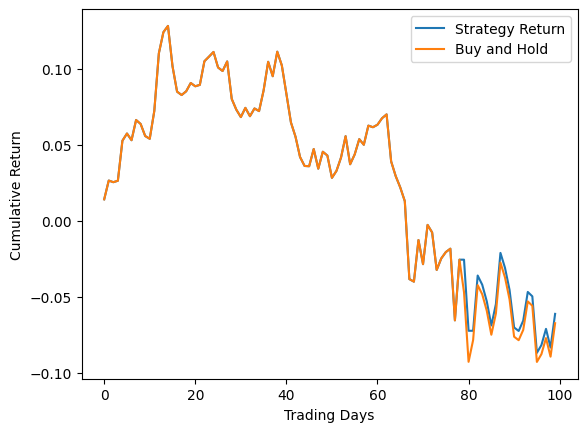

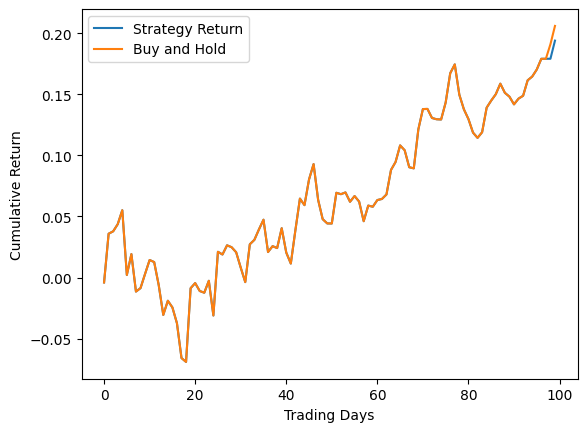

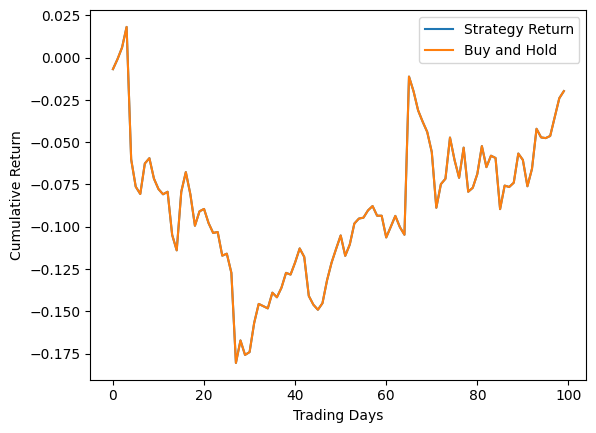

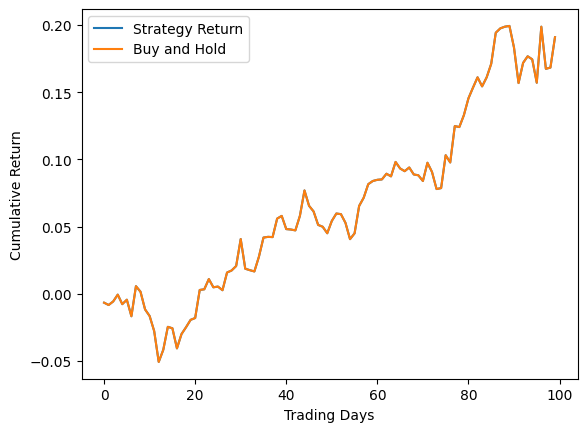

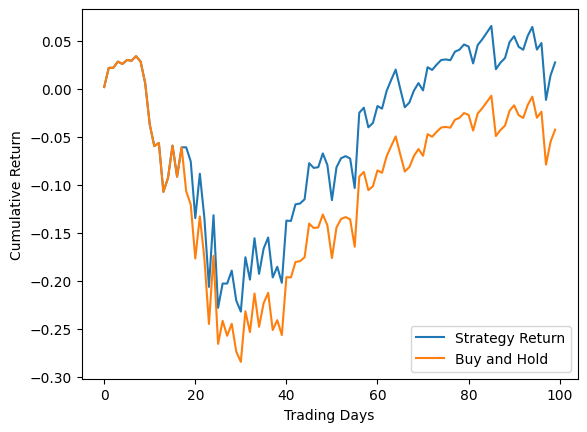

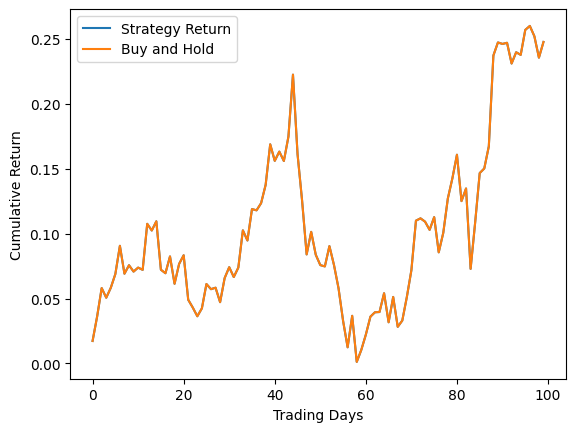

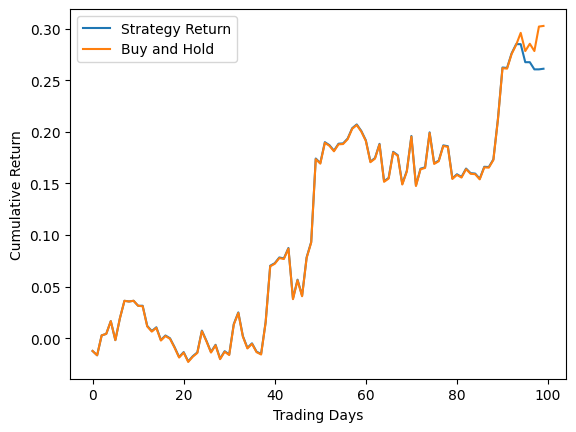

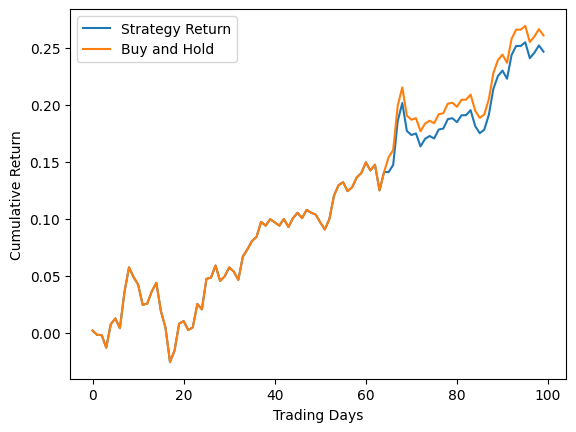

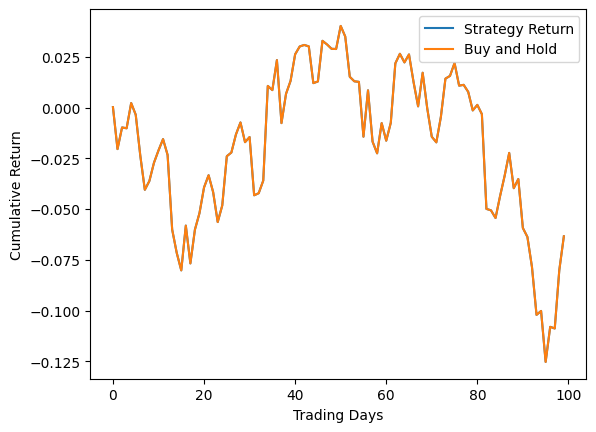

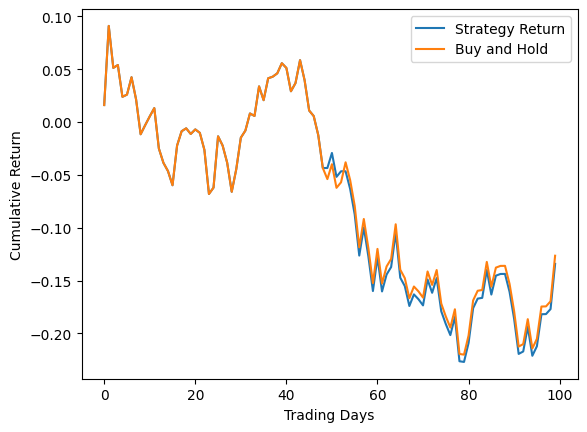

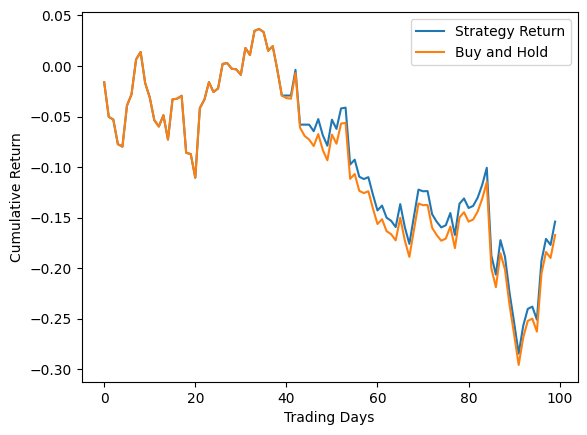

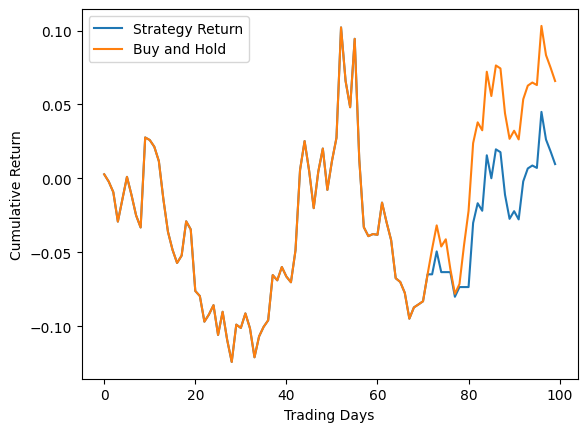

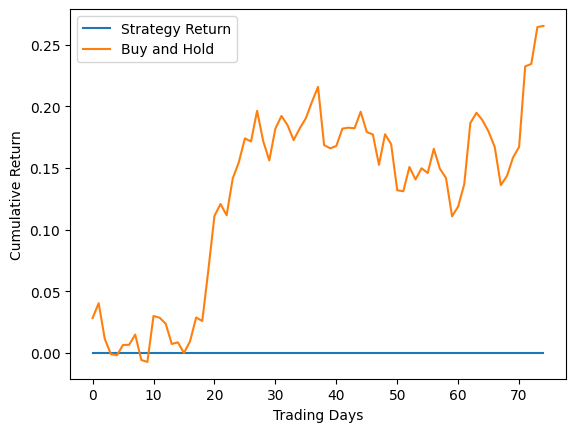

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

Because we left in the leakage we have similar results for backtesting with a single test period and a walk-forward strategy.

It looks like the results for parts a and b tend to be too good to be true when they difffer, so that we are able to get better returns than buy and hold by predicting when to move to cash, early on, thus avoiding a loss, and then it closely tracks the buy and hold strategy.

When we have worse results in part b than part a, we end up with a constant or almost constant strategy which suggests that either the model is ineffective or that it is getting stuck in the constant strategy due to randomness in the optimization procedure.

## Step 3

## Part a

We fix the error where we chose the wrong return data for the target label (overlapping with known features).

We can reduce leakage between training and test samples by introducing a gap between the training and test samples.  This will reduce leakage because we are no longer using data immediately after the training in the test data.  


In [ ]:
look_back = 30

X, y = [], []

for i in range(len(daily_returns) - look_back):
    X.append(daily_returns[i:i+look_back])
    # Assign 1 for positive differences, 0 for negative differences
    y.append(daily_returns[i+look_back])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Part b

We repeat the procedure from Step 2, with a non-anchored walk-forward validation with 500 observations in the train and 500 observations in the test set each time.  However, we now include a gap between the train and test set.

In [ ]:
def walk_forward_validation3(model, X, y, window_size=500, gap_size=30):
    predictions = []
    actual_returns = []

    for i in range(0, len(X) - window_size, window_size+gap_size):
        X_train, X_test = X[i:i+window_size], X[i+gap_size+window_size:i+gap_size+2*window_size]
        y_train, y_test = y[i:i+window_size], y[i+gap_size+window_size:i+gap_size+2*window_size]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

        # Append actual returns
        actual_returns.append(y_test)

    return predictions, actual_returns

### Multilevel Perceptron

In [ ]:


model = Sequential()
model.add(Dense(64, activation='relu', input_dim=look_back))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
predictions, actual_returns = walk_forward_validation3(model, X, y)

9/9 [==============================] - 0s 3ms/step


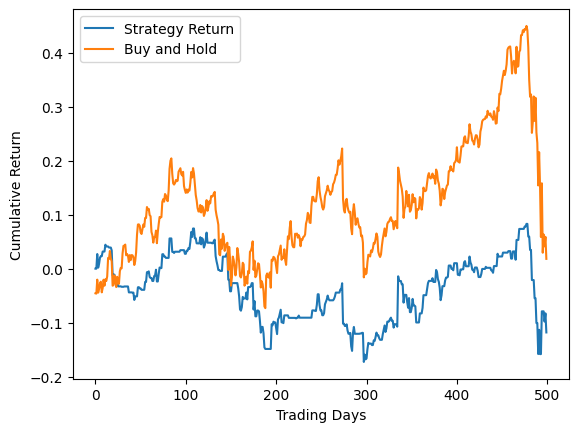

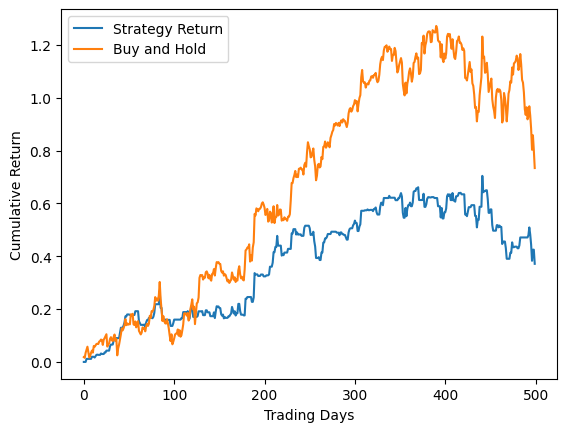

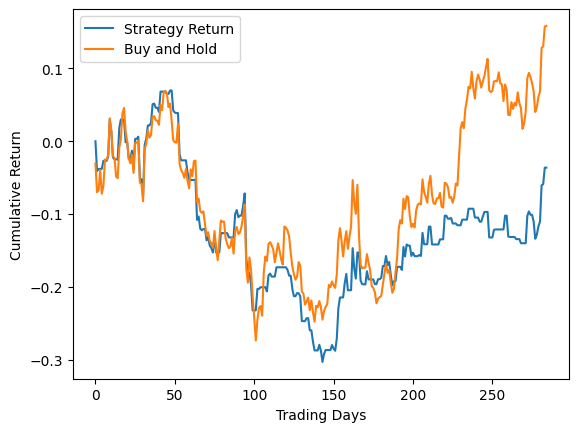

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long positionsignals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

### LSTM model

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
predictions, actual_returns = walk_forward_validation3(model, X, y)

9/9 [==============================] - 1s 116ms/step


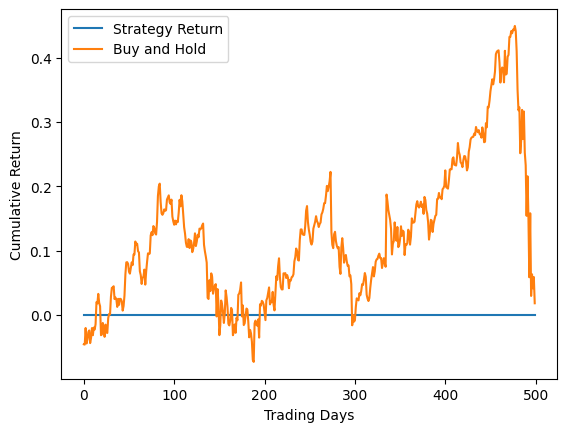

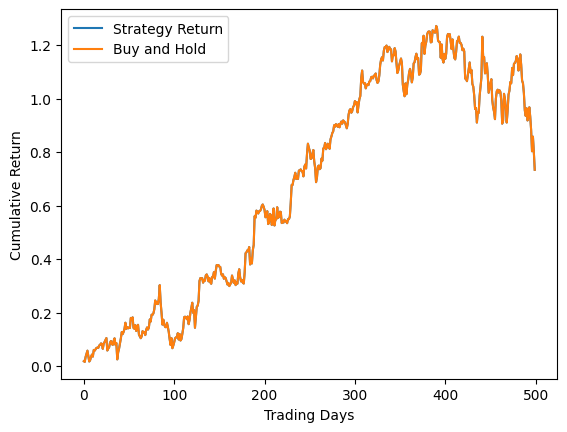

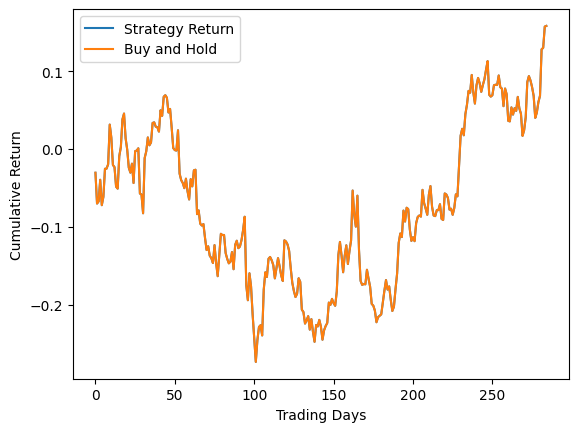

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

## Convolutional Neural Net

In [ ]:
y_data = []
for i in range(window_size, daily_returns.shape[0]):
    y_data.append(daily_returns[i])
y_data = np.array(y_data)

In [ ]:

X_train = []
window_size = 30
for i in range(window_size, stock_data.shape[0]-1):
    X_train.append(daily_returns[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])

(1875, 30)


In [ ]:
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1875, 30, 30)


(30, 30)


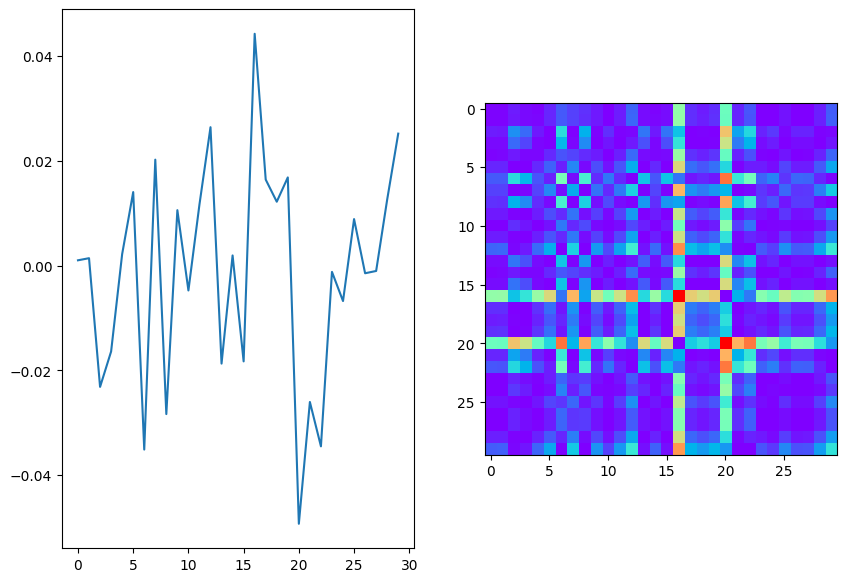

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train[0, :])
ax[1].imshow(X_train_new[0], cmap="rainbow")
print(X_train_new[0].shape)

In [ ]:

# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1875, 30, 30)

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(128, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
predictions, actual_returns = walk_forward_validation3(model, X_data, y_data)

9/9 [==============================] - 0s 16ms/step


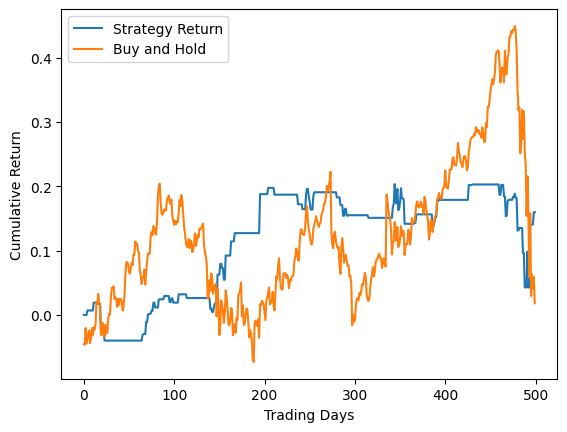

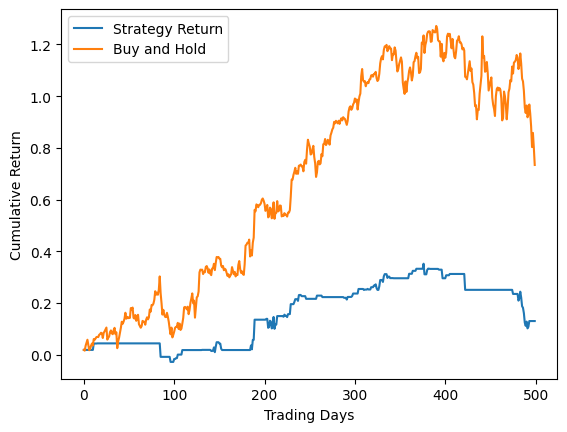

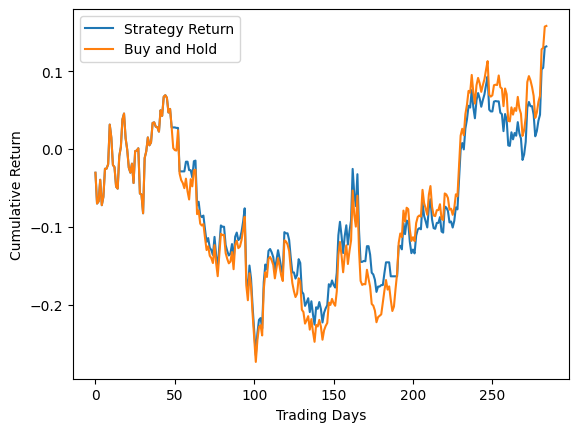

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

With the data embargoed and the leakage in the labelling fixed, we now end up lagging the buy and hold strategy.

## Part c

We do the same procedure but using 500 observations in the train and 100 observations in the test set each time.

In [ ]:
def walk_forward_validation4(model, X, y, window_size=500, test_size=100, gap_size=30):
    predictions = []
    actual_returns = []

    for i in range(0, len(X) - window_size, test_size+gap_size):
        X_train, X_test = X[i:i+window_size], X[i+gap_size+window_size:i+gap_size+test_size+window_size]
        y_train, y_test = y[i:i+window_size], y[i+gap_size+window_size:i+gap_size+test_size+window_size]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

        # Append actual returns
        actual_returns.append(y_test)

    return predictions, actual_returns

In [ ]:


model = Sequential()
model.add(Dense(64, activation='relu', input_dim=look_back))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
predictions, actual_returns = walk_forward_validation4(model, X, y)

2/2 [==============================] - 0s 7ms/step


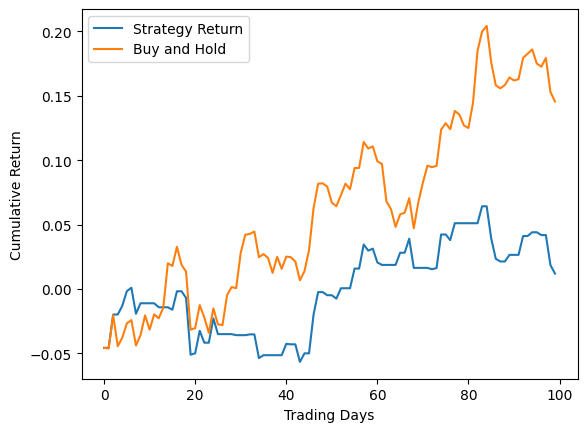

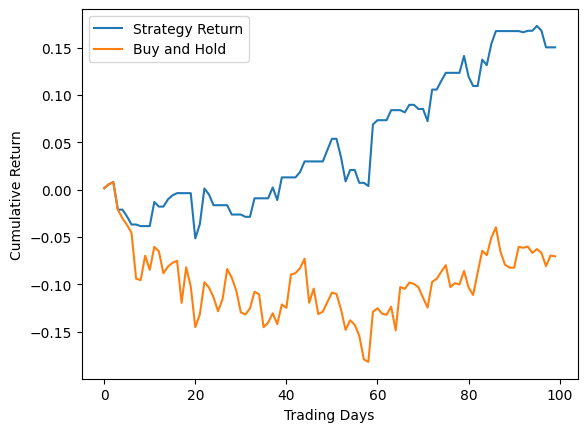

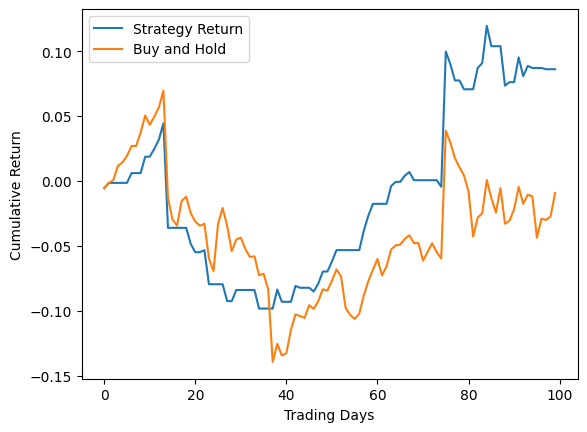

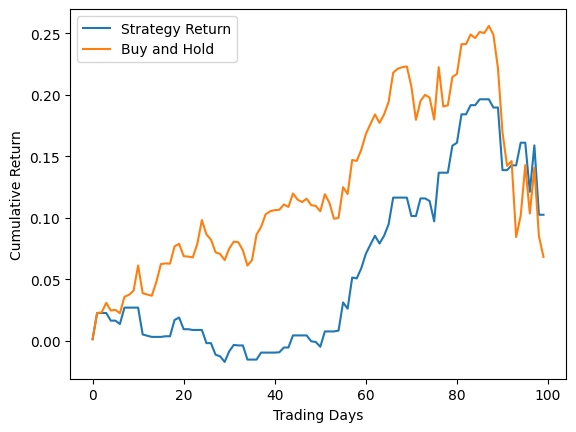

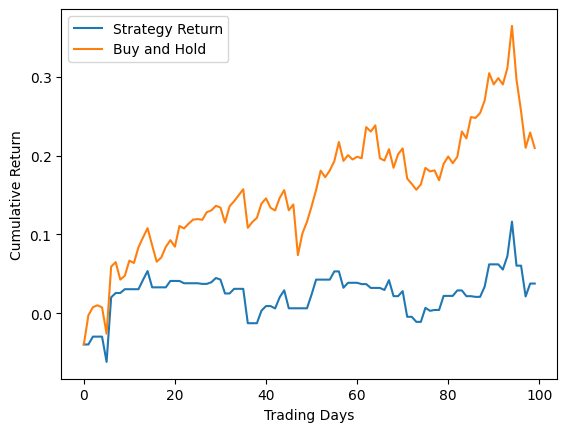

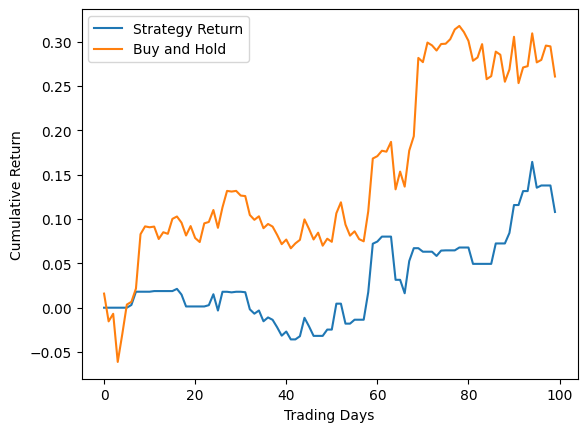

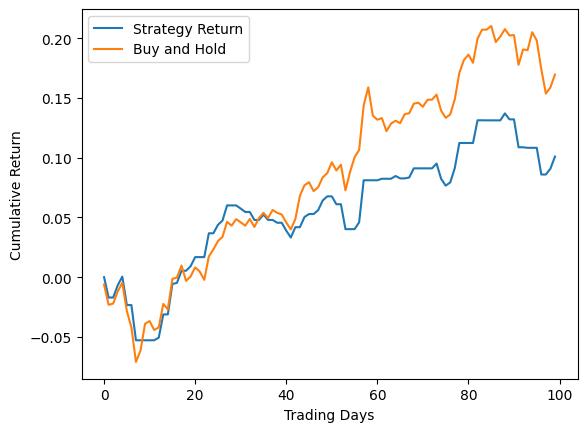

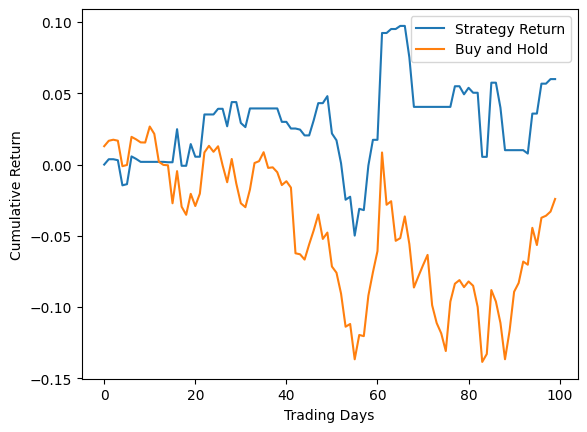

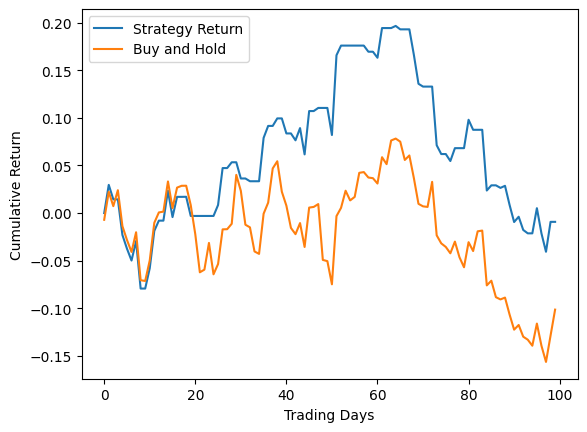

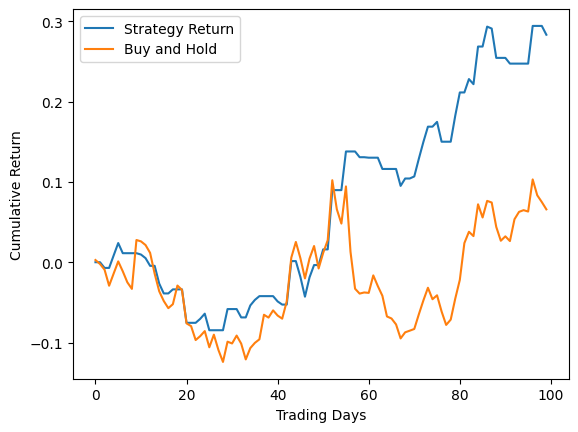

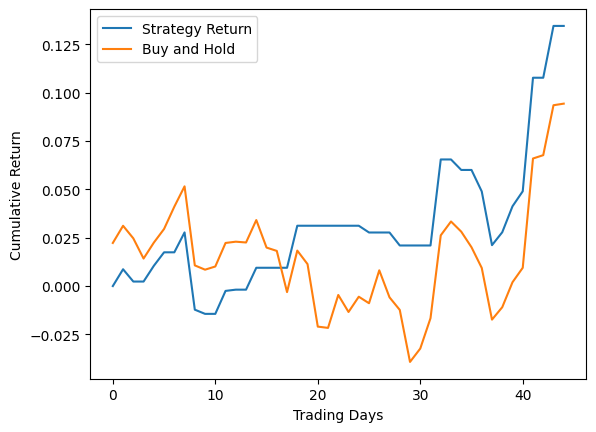

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

### Long-Term Short-Term Memory model

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
predictions, actual_returns = walk_forward_validation4(model, X, y)

2/2 [==============================] - 0s 96ms/step


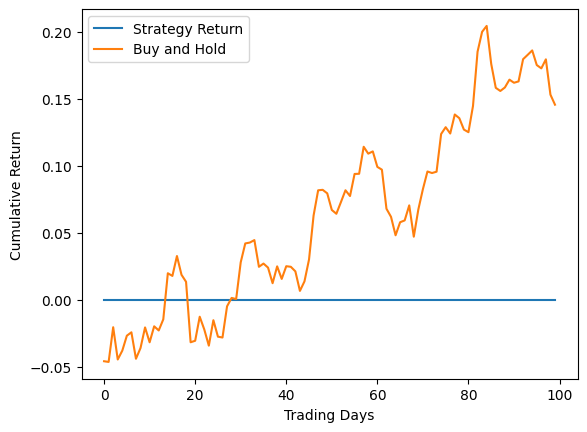

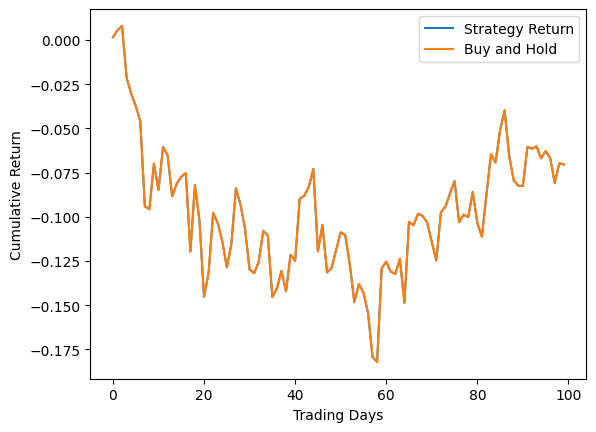

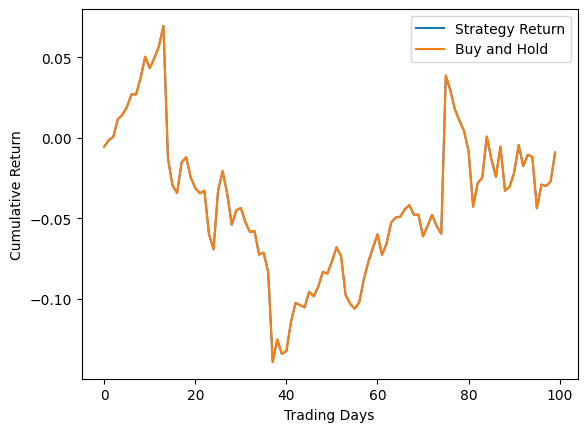

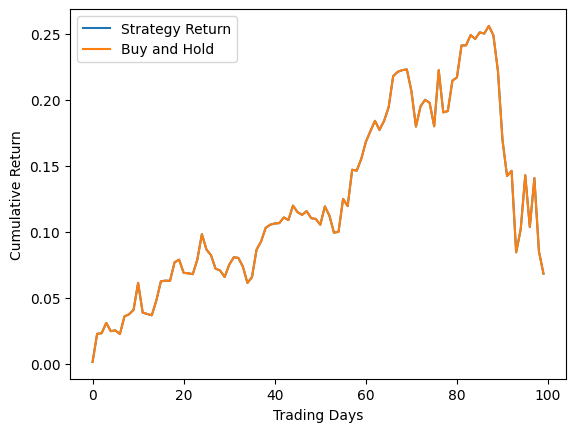

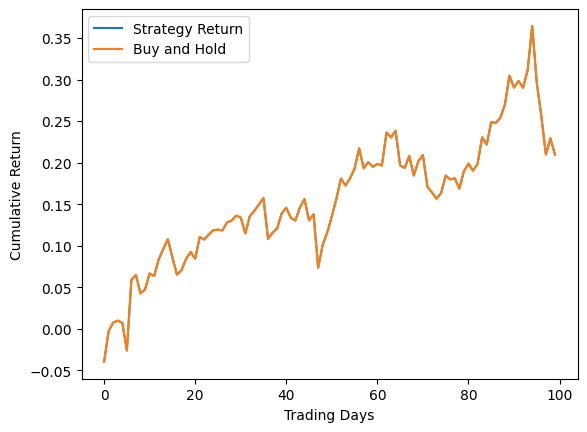

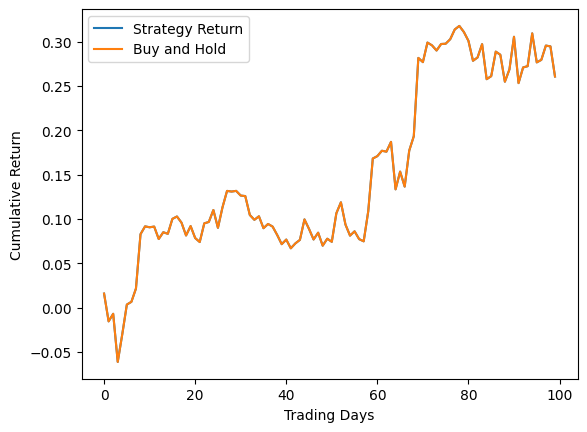

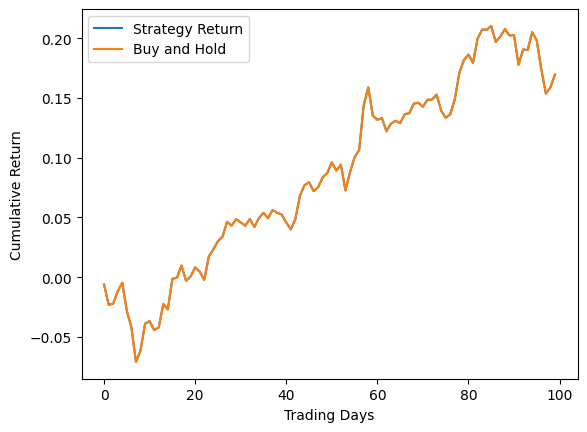

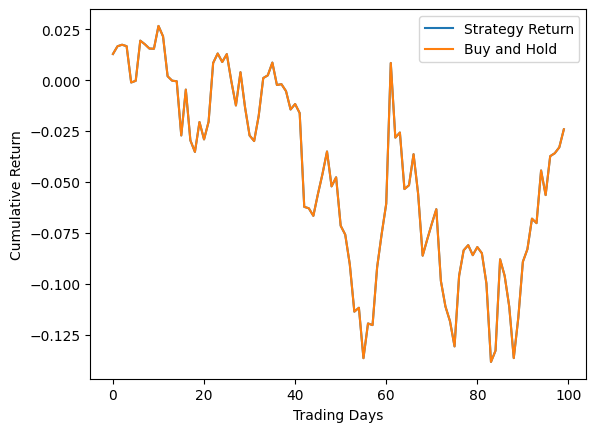

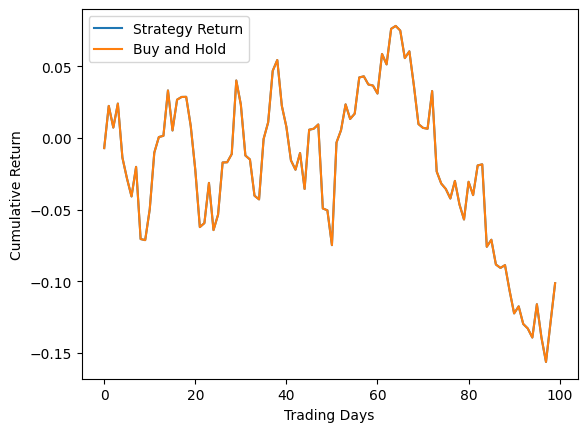

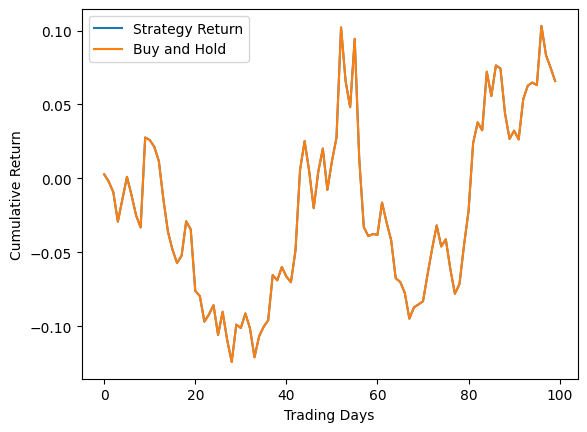

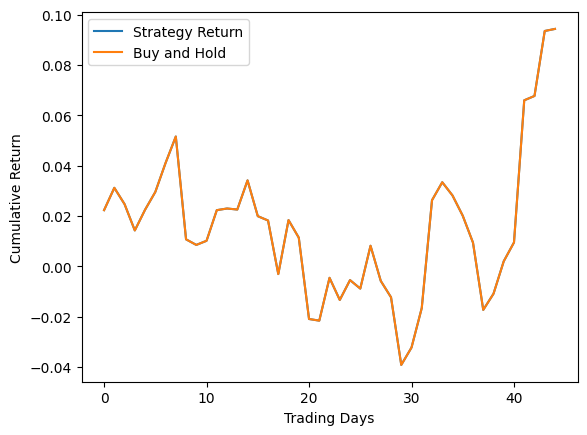

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

### Convolutional Neural Network model using Gramian Angular Field

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(128, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
predictions, actual_returns = walk_forward_validation4(model, X_data, y_data)

2/2 [==============================] - 0s 14ms/step


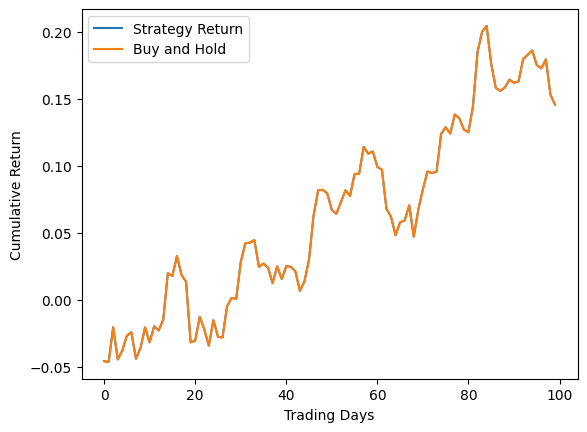

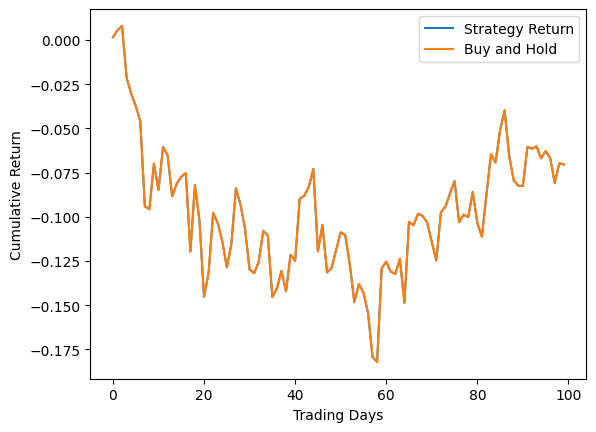

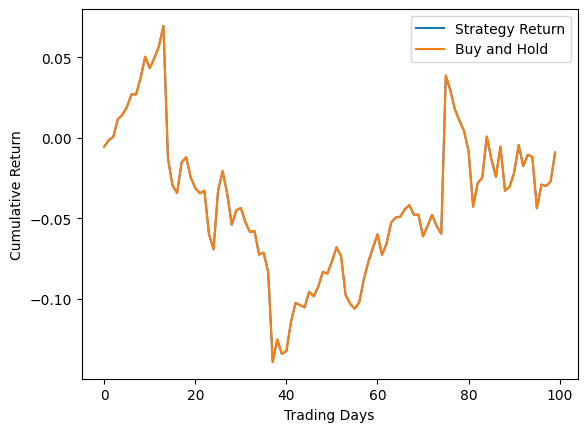

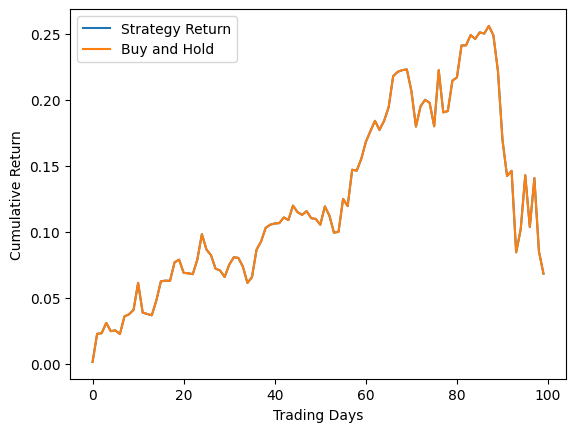

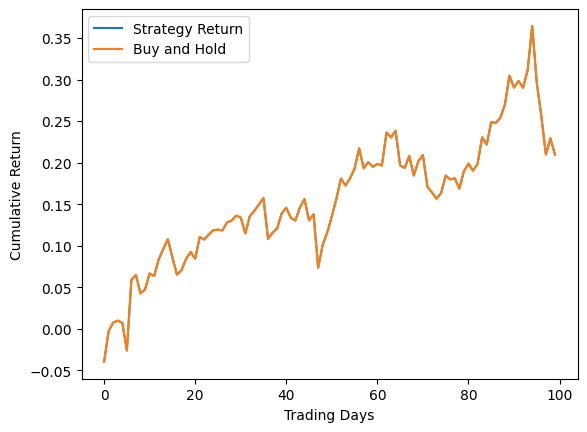

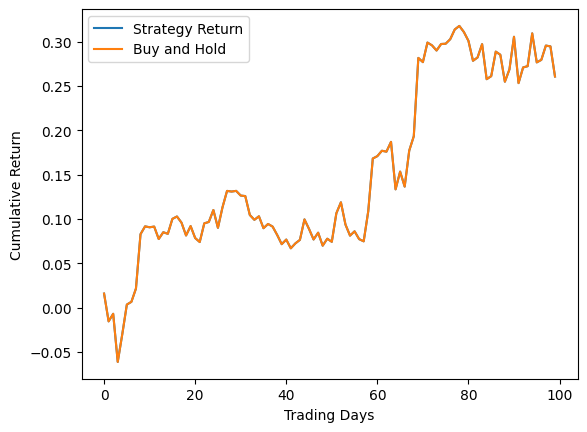

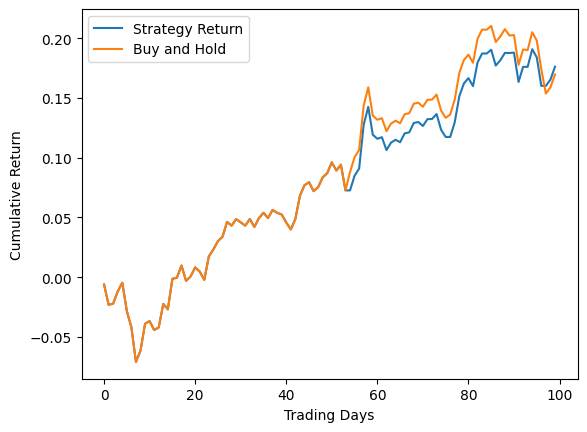

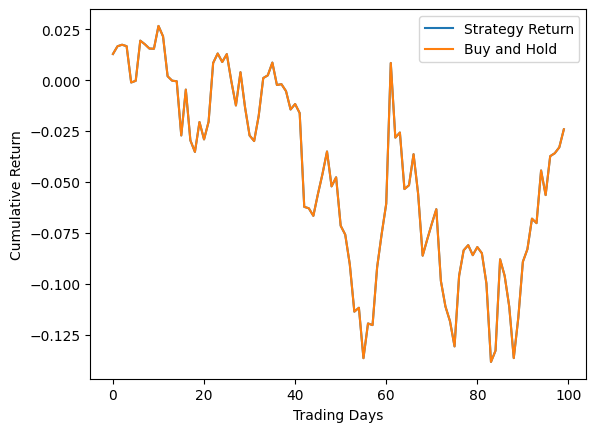

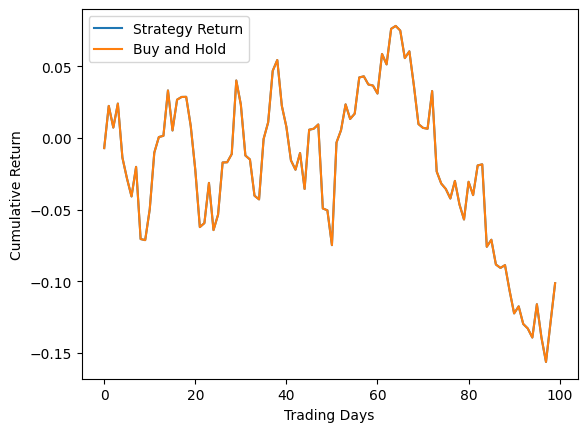

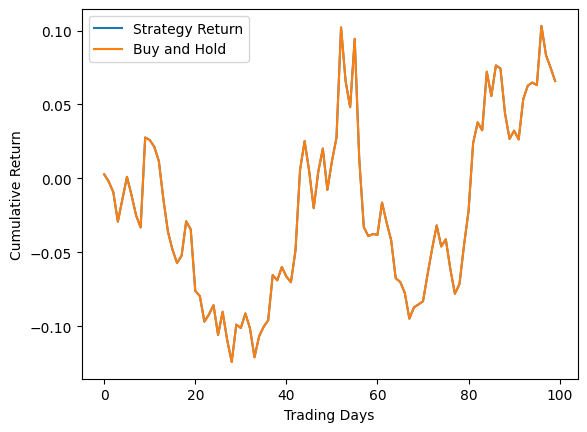

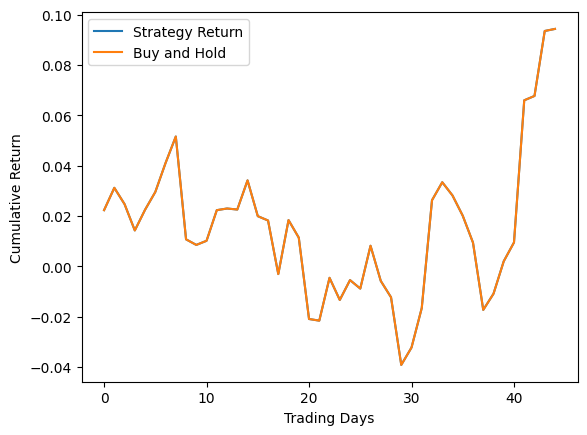

In [ ]:
signals = []
for pred_array in predictions:
    signals_array = np.where(pred_array > 0, 1, -1)
    signals.append(signals_array)
for signal, actual in zip(signals, actual_returns):
  cum_returns = []
  bh_returns = []
  bh_return = 1
  cum_return = 1
  for i in range(min(len(signal), len(actual))):
    if signal[i] == 1:
        cum_return *= (1 + actual[i])  # Update cumulative return for long position
        cum_returns.append(cum_return - 1)  # Store individual strategy return
    elif signal[i] == -1:
        cum_returns.append(cum_return - 1)  # Store zero return for cash position
    bh_return *= (1 + actual[i])
    bh_returns.append(bh_return - 1)
  plt.plot(cum_returns, label="Strategy Return")
  plt.plot(bh_returns, label="Buy and Hold")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Trading Days")
  plt.legend()
  plt.show()

## Part d

Once leakage has been eliminated, we end up having similar results to the buy and hold strategy.  The multilevel perceptron model is sometimes able to avoid losses and thereby beat the buy and hold strategy, suggesting that it shows some promise for predicting returns; however we also have instances where it does worse than the buy and hold strategy due to missing out on positive returns. We have similar results for a walk-forward validation with a test period of 100 days and a test period of 500 days.

# Bibliography

Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016.


Hochreiter, Sepp, and Jürgen Schmidhuber. "Long short-term memory." _Neural computation_ 9, no. 8 (1997): 1735-1780.

Wang, Zhenghan and Oates, Tim. "Imaging time-series to improve classification and imputation." Proceedings of the 24th International Conference on Artificial Intelligence. 2015.

Zhang, Aston, Zachary C. Lipton, Mu Li, and Alexander J. Smola. _Dive into Deep Learning_. 2023. https://d2l.ai/.
